## Contents
### 1. Libraries and data
### 2. Data Preprocessing
#### 2.1. Dealing with missing values
#### 2.2. Feature Engineering
##### 2.2.1. Фичи платформы/отеля/номера
##### 2.2.2. Страты по классам номеров
###### 2.2.2.1. 1-ый способ классификации (разбивка по классу удобства)
###### 2.2.2.2. 2-ой способ классификации (разбивка по классу удобства)
##### 2.2.3. Преобразование текстовых фичей отеля (leisures, services, room_equipped_with)
###### 2.2.3.1. Pretrained word embeddings model
###### 2.2.3.2. Токенизация, удаление стоп-слов, знаков препинания, лемматизация
###### 2.2.3.3. Непосредственно word2vec 
### 3. LATE-разметка
### 4. PSM

### 1. Libraries and data

In [75]:
import numpy as np 
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kurtosis, skew
import statistics as st

pd.options.mode.chained_assignment = None


import fasttext.util
import compress_fasttext
import re
import pymorphy2
from nltk.corpus import stopwords


import sklearn
from tqdm import tqdm
from sklearn.utils import resample
# import parfit.parfit as pf
import statsmodels.formula.api as smf
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV, ElasticNetCV, LassoCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, ParameterGrid, cross_validate, KFold, RepeatedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)



import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

In [2]:
data = pd.read_excel('Results.xlsx')

In [3]:
# отбор числовых колонок
data_numeric = data.select_dtypes(include=[np.number])
numeric_cols = data_numeric.columns.values
print(numeric_cols)

['stars' 'feedback_count' 'rating_overall' 'rating_address'
 'rating_value_for_money' 'rating_room_quality' 'rating_equip'
 'rating_cleanliness' 'rating_services' 'price']


In [4]:
# отбор нечисловых колонок
data_non_numeric = data.select_dtypes(exclude=[np.number])
non_numeric_cols = data_non_numeric.columns.values
print(non_numeric_cols)

['hotel_name' 'address' 'summary' 'internet' 'leisure' 'services'
 'room_equipped_with' 'special_rules' 'time_check_in' 'time_check_out'
 'provider_name' 'room_type' 'info_extra_options']


In [ ]:
# data.head()
# data.info()

### 2. Data Preprocessing 

#### 2.1. Dealing with missing values

Text(0.5, 1.0, '% пропусков по каждой из характеристик')

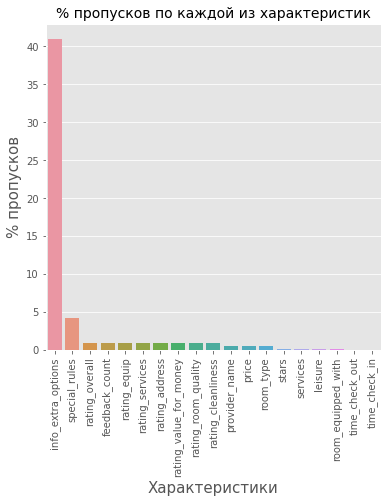

In [5]:
# хорошие новости -  в оставшейся выборке не так много пропусков
# плохие - изз-за отсутствия цен и поставщиков по 85 отелям, пришлось откинуть 19% выборки отелей

data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y=data_na)
plt.xlabel('Характеристики', fontsize=15)
plt.ylabel('% пропусков', fontsize=15)
plt.title('% пропусков по каждой из характеристик', fontsize=14)

In [12]:
# посмотрим, какую долю занимают пропуски в %
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100,3)))

hotel_name - 0.0%
address - 0.0%
stars - 0.151%
feedback_count - 0.974%
summary - 0.0%
rating_overall - 0.974%
rating_address - 0.961%
rating_value_for_money - 0.961%
rating_room_quality - 0.961%
rating_equip - 0.967%
rating_cleanliness - 0.961%
rating_services - 0.967%
internet - 0.0%
leisure - 0.094%
services - 0.101%
room_equipped_with - 0.088%
special_rules - 4.159%
time_check_in - 0.006%
time_check_out - 0.006%
provider_name - 0.553%
room_type - 0.553%
price - 0.553%
info_extra_options - 40.916%


In [13]:
# отбросим сразу те номера, по которым цены неизвестны, так как даже сгенерив замену пропусков, 
# а) можем загрязнить в итоге посчитанный эффект
# б) у нас все равно нет платформ по этим пропущенным ценам
data = data.dropna(subset=['price']).reset_index()
data.drop(['index'], axis=1, inplace=True)

In [14]:
for col in numeric_cols:
    missing = data[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  # заменяем пропуски в numeric фичах медианой
        print('imputing missing values for: {}'.format(col))
        med = data[col].median()
        data[col] = data[col].fillna(med)
# рейтинги, звездность и число отзывов можно заполнить, тк в отличие от цен, они не привязаны к платформам

imputing missing values for: stars
imputing missing values for: feedback_count
imputing missing values for: rating_overall
imputing missing values for: rating_address
imputing missing values for: rating_value_for_money
imputing missing values for: rating_room_quality
imputing missing values for: rating_equip
imputing missing values for: rating_cleanliness
imputing missing values for: rating_services


#### 2.2. Feature Engineering 

##### 2.2.1. Фичи платформы/отеля/номера

In [15]:
# фичи платформы
data['non_refundable_dummy'] = data['room_type'].str.contains('Стоимость не возвращается', flags=re.IGNORECASE, regex=True).astype(int)
data['free_cancellation_dummy'] = data['info_extra_options'].apply(lambda x: int('Бесплатная отмена' in x) if isinstance(x, str) else 0)
data['free_breakfast_dummy'] = data['info_extra_options'].apply(lambda x: int('Бесплатный завтрак' in x) if isinstance(x, str) else 0)
data['pay_at_hotel_dummy'] = data['info_extra_options'].apply(lambda x: int('Оплата в отеле' in x) if isinstance(x, str) else 0)
# фичи номера отеля
data['non_smoking_dummy'] = data['room_type'].str.contains('некурящих|Non Smoking|Non-Smoking|NONSMOKING', flags=re.IGNORECASE, regex=True).astype(int)
data['free_internet_dummy'] = data['internet'].str.contains('Бесплатный Wi-Fi', flags=re.IGNORECASE, regex=True).astype(int)
# фичи отеля
data['pets_dummy'] = data['special_rules'].apply(lambda x: int('Домашние животные разрешены по запросу' in x) if isinstance(x, str) else 0)
data['pets_dummy'] = data['pets_dummy'].groupby(data['hotel_name']).transform('mean')

##### 2.2.2. Страты по классам номеров

###### 2.2.2.1. 1-ый способ классификации (разбивка по типам номеров)

In [23]:
# def strata_1(text):
#     lst_substr =  [
#                    ['апартамент', 'apartment', 'студия', 'студио', 'studio'],
#                    ['penthouse', 'mansard', 'мансарда'], 
        
#                    ['вилла', 'villa', 'chalet', 'шале', 'bungalow', 'бунгало', 'коттедж', 'дом для отпуска', 'дом с 2 спальнями'],
        
#                    ['family', 'семейный', 'cемейный', 'семейные'],
#                    ['трехместный номер', '2 смежных двухместных номера', 'duplex'],
        
#                    ['junior suite', 'junior', 'полулюкс', 'джуниор сюит', 'джуниор', 'делюкс', 'deluxe', 'de luxe'],
#                    ['премиум', 'премьер', 'premium', 'grand premier', 'бизнес-класс', 'бизнес', 'business'],
#                    ['collection room', 'collection', 'исторический номер', 'terrace', 'historic', 'Номер Grand', 'пента плюс', 'plus room', 'playerpad'],
        
#                    ['suite', 'люкс', 'luxury', 'executive', 'presidential', 'президентский'],
#                    ['представительский', 'club king room', 'club', 'клубный номер', '1 категория', 'exclusive room'],
                   
#                    ['standard', 'standart', 'стандарт', 'classic', 'класси', 'economy', 'superior', 'супериор', 'улучшенный', 'comfort', 'комфорт'],
#                    ['двухместный', 'двухместный номер с 1 кроватью', 'double', 'двуспальн', 'номер с 2 отдельными', 'номер с 2 односпальными', 'номер с двумя односпальными', 'номер с двумя кроватями', 'double room', 'две кровати', '2 односпальные кровати', 'twin', 'твин'], 
#                    ['king', 'кинг', 'queen-size', 'queen', 'квин-сайз', 'solo', 'капсула', 'номер «парк»', 'swiss advantage', 'номер swiss signature', 'four seasons room with a view', 'номер шулдыр', 'номер шырчик', 'панорам', 'номер country', 'номер domino', 'номер romantic', 'corner', 'panorama', 'лучшая цена на данный момент', 'с ограниченными возможностями здоровья', 'jst', 'room', 'номер']
#                   ]
#     lst_return = [
#                   [1, 0, 0, 0, 0, 0, 0, 0],
#                   [1, 0, 0, 0, 0, 0, 1, 0], 
        
#                   [0, 1, 0, 0, 0, 0, 0, 0],
        
#                   [0, 0, 1, 0, 0, 0, 0, 0],
#                   [0, 0, 1, 0, 0, 0, 1, 0],
        
#                   [0, 0, 0, 1, 0, 0, 0, 0], 
#                   [0, 0, 0, 1, 0, 0, 1, 0],
#                   [0, 0, 0, 1, 0, 0, 0, 1],
        
#                   [0, 0, 0, 0, 1, 0, 0, 0],
#                   [0, 0, 0, 0, 1, 0, 1, 0],
        
#                   [0, 0, 0, 0, 0, 1, 0, 0],
#                   [0, 0, 0, 0, 0, 1, 1, 0],
#                   [0, 0, 0, 0, 0, 1, 0, 1]
#                  ]
#     for i in range(len(lst_substr)):
#         if any(map(str(text).lower().__contains__, lst_substr[i]))==True:
#             break
#     return(lst_return[i])

In [24]:
# data['apartment'] = np.nan
# data['villa'] = np.nan
# data['family'] = np.nan
# data['junior_suite'] = np.nan
# data['suite'] = np.nan
# data['standard'] = np.nan
# data['rub'] = np.nan
# data['rub_rub'] = np.nan

In [17]:
# %%time
# for i in range(15830):
#     text = data['room_type'].copy(deep=True).loc[i]
#     data['apartment'].loc[i] = strata_1(text)[0]
#     data['villa'].loc[i] = strata_1(text)[1]
#     data['family'].loc[i] = strata_1(text)[2]
#     data['junior_suite'].loc[i] = strata_1(text)[3]
#     data['suite'].loc[i] = strata_1(text)[4]
#     data['standard'].loc[i] = strata_1(text)[5]
#     data['rub'].loc[i] = strata_1(text)[6]
#     data['rub_rub'].loc[i] = strata_1(text)[7]  
#     if i%100==0:
#         print(i/15830*100,'% done')

In [26]:
# #  проверка, что нет неразмеченных
# data[(data['apartment']==0) & 
#      (data['villa']==0) &
#      (data['family']==0) &
#      (data['junior_suite']==0) &
#      (data['suite']==0) &
#      (data['standard']==0)
#     ].shape

(0, 38)

In [27]:
# data[(data['rub']==0) & (data['rub_rub']==0)].shape
# # не так уж и много мусора

(12870, 38)

###### 2.2.2.2. 2-ой способ классификации (разбивка по классу удобства)

In [18]:
def strata_2(text):
    if any(map(str(text).lower().__contains__, ['апартамент', 'apartment']))==True:
        return([1, 0, 0, 0, 0])
    elif any(map(str(text).lower().__contains__, ['студия', 'студио', 'studio']))==True:
        return([0, 0, 1, 0, 0])
    elif any(map(str(text).lower().__contains__, ['penthouse']))==True:
        return([1, 0, 0, 0, 0])
    elif any(map(str(text).lower().__contains__, ['mansard', 'мансарда']))==True:
        return([0, 0, 1, 0, 0])
    elif any(map(str(text).lower().__contains__, ['вилла', 'villa', 'chalet', 'шале', 'bungalow', 'бунгало', 'коттедж', 'дом для отпуска', 'дом с 2 спальнями']))==True:
        return([1, 0, 0, 0, 0])
    elif any(map(str(text).lower().__contains__, ['family', 'семейный', 'cемейный', 'семейные']))==True:
        return([0, 0, 1, 0, 0])
    elif any(map(str(text).lower().__contains__, ['трехместный номер', '2 смежных двухместных номера']))==True:
        return([0, 0, 1, 0, 1])
    elif any(map(str(text).lower().__contains__, ['duplex']))==True:
        return([1, 0, 0, 0, 0])
    elif any(map(str(text).lower().__contains__, ['junior suite', 'junior', 'полулюкс', 'джуниор сюит', 'джуниор', 
                                                  'делюкс', 'deluxe', 'de luxe']))==True:
        return([0, 0, 1, 0, 0])
    elif any(map(str(text).lower().__contains__, ['премиум', 'премьер', 'premium', 'grand premier']))==True:
        return([0, 1, 0, 0, 1])
    elif any(map(str(text).lower().__contains__, ['бизнес-класс', 'бизнес', 'business']))==True:
        return([0, 1, 0, 0, 0])
    elif any(map(str(text).lower().__contains__, ['collection room', 'collection', 
                                                  'исторический номер', 'historic', 'terrace']))==True:
        return([0, 0, 1, 0, 1])
    elif any(map(str(text).lower().__contains__, ['номер grand', 'пента плюс', 'plus room', ]))==True:
        return([0, 0, 1, 0, 1])
    elif any(map(str(text).lower().__contains__, ['suite', 'люкс', 'luxury']))==True:
        return([1, 0, 0, 0, 0])
    elif any(map(str(text).lower().__contains__, ['executive', 'presidential', 'президентский', 'представительский']))==True:
        return([0, 1, 0, 0, 0])
    elif any(map(str(text).lower().__contains__, ['club king room', 'club', 'клубный номер']))==True:
        return([1, 0, 0, 0, 1])
    elif any(map(str(text).lower().__contains__, ['1 категория']))==True:
        return([1, 0, 0, 0, 0])
    elif any(map(str(text).lower().__contains__, ['exclusive room']))==True:
        return([0, 0, 1, 0, 1])
    elif any(map(str(text).lower().__contains__, ['standard', 'standart', 'стандарт', 'classic', 'класси', 'economy']))==True:
        return([0, 0, 0, 1, 0])
    elif any(map(str(text).lower().__contains__, ['superior', 'супериор', 'улучшенный', 'comfort', 'комфорт']))==True:
        return([0, 0, 1, 0, 0])
    elif any(map(str(text).lower().__contains__, ['двухместный', 'double', 'две кровати', '2 односпальные кровати', 'twin', 'твин', 'номер с 2 отдельными', 'номер с 2 односпальными', 'номер с двумя односпальными', 'номер с двумя кроватями']))==True:
        return([0, 0, 0, 1, 0])
    elif any(map(str(text).lower().__contains__, ['queen-size', 'queen', 'квин-сайз', 'king-size', 'king', 'кинг']))==True:
        return([0, 0, 1, 0, 1])
    elif any(map(str(text).lower().__contains__, ['solo', 'капсула']))==True:
        return([0, 0, 0, 1, 0])
    elif any(map(str(text).lower().__contains__, ['номер «парк»', 
                                                  'swiss advantage', 'номер swiss signature', 
                                                  'four seasons room with a view', 
                                                  'номер шулдыр', 'номер шырчик', 
                                                  'номер country', 'номер domino', 'номер romantic',
                                                  'панорам', 'panorama',
                                                  'corner',
                                                  'двуспальн',
                                                  'jst', 'room', 'номер',
                                                  'с ограниченными возможностями здоровья',
                                                  'лучшая цена на данный момент']))==True:
        return([0, 0, 0, 1, 1])
    else:
        return([1, 1, 1, 1, 1])

In [19]:
data['elite'] = np.nan
data['business'] = np.nan
data['comfort'] = np.nan
data['economy'] = np.nan
data['rubbish'] = np.nan

In [20]:
%%time
for i in range(15830):
    text = data['room_type'].copy(deep=True).loc[i]
    data['elite'].loc[i] = strata_2(text)[0]
    data['business'].loc[i] = strata_2(text)[1]
    data['comfort'].loc[i] = strata_2(text)[2]
    data['economy'].loc[i] = strata_2(text)[3]
    data['rubbish'].loc[i] = strata_2(text)[4]
    if i%100==0:
        print(i/15830*100,'% done')

0.0 % done
0.6317119393556538 % done
1.2634238787113077 % done
1.8951358180669615 % done
2.5268477574226154 % done
3.1585596967782688 % done
3.790271636133923 % done
4.421983575489577 % done
5.053695514845231 % done
5.685407454200885 % done
6.3171193935565375 % done
6.948831332912192 % done
7.580543272267846 % done
8.2122552116235 % done
8.843967150979154 % done
9.475679090334808 % done
10.107391029690461 % done
10.739102969046115 % done
11.37081490840177 % done
12.002526847757423 % done
12.634238787113075 % done
13.26595072646873 % done
13.897662665824384 % done
14.529374605180037 % done
15.161086544535692 % done
15.792798483891346 % done
16.424510423247 % done
17.056222362602654 % done
17.687934301958308 % done
18.31964624131396 % done
18.951358180669615 % done
19.583070120025265 % done
20.214782059380923 % done
20.846493998736577 % done
21.47820593809223 % done
22.109917877447884 % done
22.74162981680354 % done
23.373341756159192 % done
24.005053695514846 % done
24.6367656348705 % d

In [21]:
# проверка, что нет неразмеченных
data[(data['elite']==0) &
     (data['business']==0) &
     (data['comfort']==0) &
     (data['economy']==0)].shape

(0, 35)

In [22]:
data[data['rubbish']==0].shape

(14413, 35)

In [23]:
data = data.drop(['address', 'internet', 'special_rules', 'time_check_in',
                  'time_check_out', 'info_extra_options'], axis=1)

In [24]:
data.columns
data.shape

(15830, 29)

##### 2.2.3. Преобразование текстовых фичей отеля

###### 2.2.3.1. Pretrained word embeddings model

In [ ]:
# fasttext.util.download_model('ru', if_exists='ignore')  # russian
# ft = fasttext.load_model('cc.ru.300.bin')
# ft.save_model('cc.ru.300.bin')
# ft.get_dimension()

In [25]:
comp = fasttext.load_model('cc.ru.300.bin')
fasttext.util.reduce_model(comp, 5)
comp.save_model('cc.ru.5.bin')
comp.get_dimension()

5

In [ ]:
# проверка векторизации отдельных слов
# ft.get_sentence_vector('вилла уютный хороший')
# ft.get_nearest_neighbors('экият')
# ft.get_word_vector(new_data.loc[i, 'summary'][j])

###### 2.2.3.2. Токенизация, удаление стоп-слов, знаков препинания, лемматизация

In [26]:
# нам нужно обработать текстовые фичи:
morph = pymorphy2.MorphAnalyzer()
stops = set(stopwords.words("english")) | set(stopwords.words("russian"))

def review_to_wordlist(review):
    #1)
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2)
    words = review_text.lower().split()
    #3)
    words = [w for w in words if not w in stops]
    #4)
    words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

###### 2.2.3.3. Непосредственно word2vec

#### Summary 

In [27]:
# будем работать с уникальными текстовыми фичами, затем конкатенируем к датасету
summary = data[['hotel_name', 'summary']].drop_duplicates().reset_index()
summary.drop(['index'], axis=1, inplace=True)
summary

,hotel_name,summary
0,Hills Polyana Hotel,Этот HILLS POLYANA Hotel & SPA в городе Красна...
1,Kazan Palace By Tasigo,Отель Kazan Palace by Tasıgo находится в самом...
2,Business Club Hotel Razumovsky,Расположение Этот отель расположен в Омске. Бл...
3,Butik-Hotel Vetryakov,Бутик-отель «Ветряков» — первый отель-путешест...
4,Park Hotel,Парк-Отель находится в самом сердце города Иже...
...,...,...
356,U Istoka Hotel,Отель «﻿У истока﻿» — хороший вариант в городе ...
357,Bogemia Private Residence,Частная резиденция «Богемия» находится в самом...
358,Гостиница Европа Хабаровск,Гостиница расположена в 5 км от центра Хабаров...
359,Hotel Slavyansky,"Отель «Славянский» расположен в Липецке, в 8 к..."


In [28]:
%%time
summary['summary'] = summary['summary'].apply(review_to_wordlist)

Wall time: 3.05 s


In [29]:
summary

,hotel_name,summary
0,Hills Polyana Hotel,"[hills, polyana, hotel, spa, город, красный, п..."
1,Kazan Palace By Tasigo,"[отель, kazan, palace, tas, go, находиться, са..."
2,Business Club Hotel Razumovsky,"[расположение, отель, расположить, омск, близк..."
3,Butik-Hotel Vetryakov,"[бутик, отель, ветряк, первый, отель, путешест..."
4,Park Hotel,"[парк, отель, находиться, сам, сердце, город, ..."
...,...,...
356,U Istoka Hotel,"[отель, исток, хороший, вариант, город, иркутс..."
357,Bogemia Private Residence,"[частный, резиденция, богемия, находиться, сам..."
358,Гостиница Европа Хабаровск,"[гостиница, расположить, км, центр, хабаровск,..."
359,Hotel Slavyansky,"[отель, славянский, расположить, липецк, км, с..."


In [30]:
review_vector = list()
for i in range(361):
    n = len(summary.loc[i, 'summary'])
    emb = np.zeros(5)
    for j in range(n):
        emb = emb + comp.get_word_vector(summary.loc[i, 'summary'][j])
    emb = emb/n
    review_vector.append(emb)

In [31]:
review_vector

[array([ 0.07773622,  0.00223836,  0.04950331, -0.02348899,  0.01407546]),
 array([ 0.03877817, -0.00728372,  0.0575252 ,  0.00849607,  0.0357764 ]),
 array([-0.02878857, -0.00129298,  0.02911935, -0.01365711,  0.06184334]),
 array([-0.04704674, -0.02880363,  0.03190633,  0.00813087,  0.03203058]),
 array([-0.02213097, -0.03194936,  0.03671265,  0.0152325 ,  0.02305086]),
 array([-0.00196479, -0.02292963,  0.04269466,  0.00030851,  0.02315897]),
 array([-0.01867844, -0.03154741,  0.02464898,  0.00073622,  0.02783631]),
 array([ 0.01071634, -0.02931537,  0.03970802, -0.00972202,  0.018866  ]),
 array([ 0.00433246, -0.03366912,  0.03284274,  0.00463135,  0.02687482]),
 array([ 0.01472826, -0.01845673,  0.02607899,  0.00957339,  0.0233416 ]),
 array([-0.00296461, -0.01838074,  0.03036748, -0.01844307,  0.01557964]),
 array([ 0.03532419, -0.0089397 ,  0.02758225, -0.00884104,  0.02426788]),
 array([ 0.02735357, -0.01272336,  0.03969704, -0.00813988,  0.00929832]),
 array([ 0.01193978, -0.0

In [32]:
summary_vector = pd.Series(review_vector)
summary = summary.assign(summary_vector=summary_vector)
summary.drop(['summary'], axis=1, inplace=True)

In [33]:
data = pd.merge(data, summary, how="left", on="hotel_name")

#### Leisure

In [34]:
# будем работать с уникальными текстовыми фичами, затем конкатенируем к датасету
leisure = data[['hotel_name', 'leisure']].drop_duplicates().dropna()
leisure = leisure.reset_index()
leisure.drop(['index'], axis=1, inplace=True)
leisure

,hotel_name,leisure
0,Hills Polyana Hotel,Казино
1,Kazan Palace By Tasigo,Фитнес-центр
2,Business Club Hotel Razumovsky,"Трансфер из аэропорта, Бизнес-центр"
3,Park Hotel,"Открытый теннисный корт, Стол для бильярда"
4,Inostranez Hotel,Пеший туризм
...,...,...
355,U Istoka Hotel,"Услуга ""Разбудите меня"", Ежедневная уборка, Фа..."
356,Bogemia Private Residence,Пеший туризм
357,Гостиница Европа Хабаровск,"Массаж, Фитнес-центр"
358,Hotel Slavyansky,Стол для бильярда


In [35]:
%%time
leisure['leisure'] = leisure['leisure'].apply(review_to_wordlist)

Wall time: 472 ms


In [36]:
leisure_vector = list()
for i in range(360):
    n = len(leisure.loc[i, 'leisure'])
    emb = np.zeros(5)
    for j in range(n):
        emb = emb + comp.get_word_vector(leisure.loc[i, 'leisure'][j])
    emb = emb/n
    leisure_vector.append(emb)

In [37]:
leisure_vector

[array([-0.05016148, -0.02118113, -0.02109808,  0.04885235, -0.00621443]),
 array([ 0.01986972, -0.06061594,  0.02478198, -0.03796078,  0.05811224]),
 array([-0.04098891, -0.04329012,  0.02180233, -0.01029407, -0.0171911 ]),
 array([0.01492523, 0.00281582, 0.0231975 , 0.0477395 , 0.12348451]),
 array([ 0.01028627, -0.05157843,  0.05360983,  0.03633438, -0.00575498]),
 array([-0.00047997, -0.03211444,  0.00968601,  0.00078949,  0.07711641]),
 array([ 0.01986972, -0.06061594,  0.02478198, -0.03796078,  0.05811224]),
 array([-0.00163589, -0.03461303,  0.03914703, -0.01734918,  0.11507141]),
 array([-0.0071821 , -0.0176374 ,  0.02551545, -0.02049916,  0.03875663]),
 array([-0.01553302, -0.03155261,  0.03116564, -0.03398676,  0.07982771]),
 array([-0.03261069, -0.07326194,  0.03280861, -0.02511827,  0.07785732]),
 array([-0.01568526, -0.0472648 ,  0.02126244, -0.02208123,  0.12318317]),
 array([ 0.01986972, -0.06061594,  0.02478198, -0.03796078,  0.05811224]),
 array([-0.00089111, -0.043095

In [38]:
leisure_vector = pd.Series(leisure_vector)
leisure = leisure.assign(leisure_vector=leisure_vector)
leisure.drop(['leisure'], axis=1, inplace=True)

In [39]:
data = pd.merge(data, leisure, how="left", on="hotel_name")

#### Services

In [40]:
# будем работать с уникальными текстовыми фичами, затем конкатенируем к датасету
services = data[['hotel_name', 'services']].drop_duplicates().dropna()
services = services.reset_index()
services.drop(['index'], axis=1, inplace=True)
services

,hotel_name,services
0,Hills Polyana Hotel,"Заказ билетов, Ежедневная уборка, Услуги консь..."
1,Kazan Palace By Tasigo,"Конференц-залы, Заказ билетов, Бизнес-центр, Е..."
2,Business Club Hotel Razumovsky,"Трансфер из аэропорта, Бизнес-центр"
3,Park Hotel,"Конференц-залы, Свадьбы, Заказ билетов, Бизнес..."
4,Inostranez Hotel,"Конференц-залы, Заказ билетов, Бизнес-центр, У..."
...,...,...
355,U Istoka Hotel,"Услуга ""Разбудите меня"", Ежедневная уборка, Фа..."
356,Bogemia Private Residence,"Трансфер (бесплатно), Услуга ""Разбудите меня"",..."
357,Гостиница Европа Хабаровск,"Услуга ""Разбудите меня"", Хамам (турецкая баня)..."
358,Hotel Slavyansky,"Услуга ""Разбудите меня"", Ежедневная уборка, Ха..."


In [41]:
%%time
services['services'] = services['services'].apply(review_to_wordlist)

Wall time: 1.77 s


In [42]:
services_vector = list()
for i in range(360):
    n = len(services.loc[i, 'services'])
    emb = np.zeros(5)
    for j in range(n):
        emb = emb + comp.get_word_vector(services.loc[i, 'services'][j])
    emb = emb/n
    services_vector.append(emb)

In [43]:
services_vector

[array([ 0.00173948, -0.01232719,  0.02330268, -0.04867933,  0.04370346]),
 array([-0.01212073, -0.02228563,  0.01487432, -0.0345226 ,  0.02249843]),
 array([-0.04098891, -0.04329012,  0.02180233, -0.01029407, -0.0171911 ]),
 array([-0.02238747, -0.02723525,  0.01470133, -0.01870153,  0.01704987]),
 array([-0.01135634, -0.01924128,  0.02106102, -0.02217986,  0.01888657]),
 array([ 0.01372553, -0.0226897 ,  0.01916711, -0.00775877,  0.04391535]),
 array([-0.02119351, -0.01320142,  0.01914114, -0.04191554,  0.03674114]),
 array([-0.00975629, -0.00731751,  0.01921297, -0.02865326,  0.04688561]),
 array([-0.0071821 , -0.0176374 ,  0.02551545, -0.02049916,  0.03875663]),
 array([-0.00829808, -0.00946308,  0.01862638, -0.0153549 ,  0.04066672]),
 array([-0.01148533, -0.01011506,  0.0151822 , -0.02956004,  0.03993027]),
 array([-0.02024287, -0.01746725,  0.02339677, -0.02272239,  0.03835985]),
 array([-0.01628177, -0.006753  ,  0.02056005, -0.04758273,  0.01890055]),
 array([-0.01820901, -0.0

In [44]:
services_vector = pd.Series(services_vector)
services = services.assign(services_vector=services_vector)
services.drop(['services'], axis=1, inplace=True)

In [45]:
data = pd.merge(data, services, how="left", on="hotel_name")

#### Room_equipped_with

In [46]:
# будем работать с уникальными текстовыми фичами, затем конкатенируем к датасету
room_equipped_with = data[['hotel_name', 'room_equipped_with']].drop_duplicates().dropna()
room_equipped_with = room_equipped_with.reset_index()
room_equipped_with.drop(['index'], axis=1, inplace=True)
room_equipped_with

,hotel_name,room_equipped_with
0,Hills Polyana Hotel,"Ресторан, Бар/Лаунж, Дезинфицириующий гель для..."
1,Kazan Palace By Tasigo,"Банкомат, Ресторан, Дезинфицириующий гель для ..."
2,Business Club Hotel Razumovsky,"Обслуживание номеров, Прачечная самообслуживан..."
3,Park Hotel,"Ресторан, Номера для курящих, Бар/Лаунж, Дезин..."
4,Inostranez Hotel,"Банкомат, Ресторан, Экспресс-регистрация выезд..."
...,...,...
355,U Istoka Hotel,"Курение запрещено, Электрочайник, Ресторан, Мы..."
356,Bogemia Private Residence,"Семейные номера, Сейф, Огнетушитель, Прачечная..."
357,Гостиница Европа Хабаровск,"Электрочайник, Сейф, Зона для отдыха, Прачечна..."
358,Hotel Slavyansky,"Первый этаж, Номера для курящих, Удлиненные кр..."


In [47]:
%%time
room_equipped_with['room_equipped_with'] = room_equipped_with['room_equipped_with'].apply(review_to_wordlist)

Wall time: 8.92 s


In [48]:
room_equipped_with_vector = list()
for i in range(360):
    n = len(room_equipped_with.loc[i, 'room_equipped_with'])
    emb = np.zeros(5)
    for j in range(n):
        emb = emb + comp.get_word_vector(room_equipped_with.loc[i, 'room_equipped_with'][j])
    emb = emb/n
    room_equipped_with_vector.append(emb)

In [49]:
room_equipped_with_vector

[array([ 0.01073539, -0.00558691,  0.01820795, -0.01966389,  0.12264998]),
 array([ 0.00123365,  0.0009197 ,  0.02058001, -0.01575258,  0.12523332]),
 array([ 0.01478247, -0.00443865,  0.0089502 , -0.05406876,  0.10185734]),
 array([ 0.04247042,  0.00151369,  0.01856063, -0.01860619,  0.11939794]),
 array([ 0.04045823,  0.0192069 ,  0.03509376, -0.02907765,  0.08322559]),
 array([ 0.00785939, -0.0031453 ,  0.01371024, -0.02697554,  0.11056693]),
 array([-0.00825669,  0.00114105,  0.01275421, -0.02604329,  0.10269641]),
 array([-0.00334077,  0.00592416,  0.01218338, -0.02297744,  0.12020274]),
 array([-0.00872376,  0.00222291,  0.01048586, -0.03230919,  0.09707666]),
 array([ 0.00078371,  0.0031454 ,  0.01048321, -0.02530629,  0.10685001]),
 array([-0.00701012,  0.00778757,  0.01061322, -0.02631547,  0.10665494]),
 array([-0.0128663 ,  0.00316322,  0.01144358, -0.0271549 ,  0.10217787]),
 array([-0.00349868,  0.00537998,  0.00628403, -0.02728227,  0.0932394 ]),
 array([-0.00472418,  0.0

In [50]:
room_equipped_with_vector = pd.Series(room_equipped_with_vector)
room_equipped_with = room_equipped_with.assign(room_equipped_with_vector=room_equipped_with_vector)
room_equipped_with.drop(['room_equipped_with'], axis=1, inplace=True)

In [51]:
data = pd.merge(data, room_equipped_with, how="left", on="hotel_name")

#### Заполнение пропусков в эмбеддингах

In [ ]:
# заменим медианными эмбеддингами пропуски для предоставляемых развлечений, сервисов, предметов, которыми оборудован номер 
# sum(leisure_vector)/len(leisure_vector)
# sum(services_vector)/len(services_vector)
# sum(room_equipped_with_vector)/len(room_equipped_with_vector)

In [52]:
leisure_list = [-0.00164745, -0.03980778,  0.02657196, -0.01819926,  0.08041528]
services_list = [-0.01193289, -0.01274013,  0.02104153, -0.029035  ,  0.0424484 ]
room_equipped_with_list = [-0.00206908,  0.00427169,  0.01267513, -0.02427585,  0.11035964]

In [53]:
data['leisure_vector'].loc[(data['leisure_vector'].isna())] = data['leisure_vector'].loc[(data['leisure_vector'].isna())].apply(lambda x: leisure_list)
data['services_vector'].loc[(data['services_vector'].isna())] = data['services_vector'].loc[(data['services_vector'].isna())].apply(lambda x: services_list)
data['room_equipped_with_vector'].loc[(data['room_equipped_with_vector'].isna())] = data['room_equipped_with_vector'].loc[(data.copy()['room_equipped_with_vector'].isna())].apply(lambda x: room_equipped_with_list)
# data[['leisure_vector', 'services_vector', 'room_equipped_with_vector']][data['hotel_name']=='Butik-Hotel Vetryakov']

In [54]:
vectors_split_0 = pd.DataFrame(data['summary_vector'].to_list(), columns=['summary_1', 'summary_2', 'summary_3', 'summary_4', 'summary_5'])
vectors_split_1 = pd.DataFrame(data['leisure_vector'].to_list(), columns=['leisure_1', 'leisure_2', 'leisure_3', 'leisure_4', 'leisure_5'])
vectors_split_2 = pd.DataFrame(data['services_vector'].to_list(), columns=['service_1', 'service_2', 'service_3', 'service_4', 'service_5'])
vectors_split_3 = pd.DataFrame(data['room_equipped_with_vector'].to_list(), columns=['r_eq_with_1', 'r_eq_with_2', 'r_eq_with_3', 'r_eq_with_4', 'r_eq_with_5'])
data = pd.concat([data, vectors_split_0, vectors_split_1, vectors_split_2, vectors_split_3], axis=1)

In [56]:
data = data[['hotel_name', 'provider_name', 'price', 'stars', 'feedback_count', 
             
#              'apartment', 'villa', 'family', 'junior_suite', 'suite', 'standard', 'rub', 'rub_rub', 
             'elite', 'business', 'comfort', 'economy', 'rubbish',
             
             'rating_overall', 'rating_address', 'rating_value_for_money', 'rating_room_quality',
             'rating_equip', 'rating_cleanliness', 'rating_services',
             
             'non_refundable_dummy', 'free_cancellation_dummy', 'free_breakfast_dummy', 'pay_at_hotel_dummy',
             'non_smoking_dummy', 'free_internet_dummy', 'pets_dummy', 
             
             'summary_1', 'summary_2', 'summary_3', 'summary_4', 'summary_5', 
             'leisure_1', 'leisure_2', 'leisure_3', 'leisure_4', 'leisure_5', 
             'service_1', 'service_2', 'service_3', 'service_4', 'service_5', 
             'r_eq_with_1', 'r_eq_with_2', 'r_eq_with_3', 'r_eq_with_4', 'r_eq_with_5']]
data.shape

(15830, 44)

In [58]:
# descriptive statistics
stats = data.describe().astype(float)
stats

,price,stars,feedback_count,elite,business,comfort,economy,rubbish,rating_overall,rating_address,...,service_1,service_2,service_3,service_4,service_5,r_eq_with_1,r_eq_with_2,r_eq_with_3,r_eq_with_4,r_eq_with_5
count,1.583000e+04,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,...,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000
mean,1.555565e+04,4.249337,2159.570057,0.177764,0.084397,0.417372,0.320467,0.089514,8.906563,9.257246,...,-0.012179,-0.012830,0.020783,-0.026980,0.042504,-0.003321,0.003984,0.012274,-0.024357,0.109538
std,3.057226e+04,0.644393,2103.648696,0.382326,0.277991,0.493141,0.466671,0.285493,0.387821,0.436363,...,0.006089,0.005829,0.005552,0.014732,0.012501,0.008183,0.003734,0.002632,0.003764,0.009627
min,3.290000e+03,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.300000,7.000000,...,-0.040989,-0.043290,-0.025765,-0.069261,-0.017191,-0.024677,-0.006497,0.005353,-0.054069,0.074945
25%,5.988000e+03,4.000000,895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.700000,9.100000,...,-0.016375,-0.015841,0.017655,-0.038300,0.034665,-0.008026,0.002014,0.010489,-0.026535,0.104298
50%,8.153000e+03,4.000000,1579.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,9.400000,...,-0.011899,-0.012615,0.021018,-0.025475,0.042681,-0.004475,0.003772,0.011910,-0.024389,0.109703
75%,1.384475e+04,5.000000,2878.000000,0.000000,0.000000,1.000000,1.000000,0.000000,9.200000,9.600000,...,-0.007979,-0.009188,0.023495,-0.016495,0.052055,-0.001107,0.005708,0.013568,-0.021980,0.115001
max,1.032655e+06,5.000000,13966.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.700000,9.900000,...,0.013726,0.009845,0.051933,0.077146,0.094829,0.045796,0.021909,0.035094,-0.010827,0.165232


### Фильтрация данных на выбросы по ценам

In [196]:
# Уберем откровенные выбросы по ценам
d = data[data['price']<=50000]
d.reset_index()
d.head()

,hotel_name,provider_name,price,stars,feedback_count,elite,business,comfort,economy,rubbish,...,service_1,service_2,service_3,service_4,service_5,r_eq_with_1,r_eq_with_2,r_eq_with_3,r_eq_with_4,r_eq_with_5
0,Hills Polyana Hotel,Agoda.com,14280.0,5.0,1579.0,0.0,0.0,1.0,0.0,0.0,...,0.001739,-0.012327,0.023303,-0.048679,0.043703,0.010735,-0.005587,0.018208,-0.019664,0.12265
1,Hills Polyana Hotel,ostrovok.ru,15743.0,5.0,1579.0,0.0,0.0,1.0,0.0,0.0,...,0.001739,-0.012327,0.023303,-0.048679,0.043703,0.010735,-0.005587,0.018208,-0.019664,0.12265
2,Hills Polyana Hotel,ostrovok.ru,15743.0,5.0,1579.0,0.0,0.0,1.0,0.0,0.0,...,0.001739,-0.012327,0.023303,-0.048679,0.043703,0.010735,-0.005587,0.018208,-0.019664,0.12265
3,Hills Polyana Hotel,ostrovok.ru,16265.0,5.0,1579.0,0.0,0.0,1.0,0.0,0.0,...,0.001739,-0.012327,0.023303,-0.048679,0.043703,0.010735,-0.005587,0.018208,-0.019664,0.12265
4,Hills Polyana Hotel,ostrovok.ru,16265.0,5.0,1579.0,0.0,0.0,1.0,0.0,0.0,...,0.001739,-0.012327,0.023303,-0.048679,0.043703,0.010735,-0.005587,0.018208,-0.019664,0.12265


In [197]:
# for d['hotel_name'].iloc[i] in range(len(d['hotel_name'].unique())):
d['relevant'] = np.where((d['provider_name']=='Booking.com') | (d['provider_name']=='Agoda.com'), 1, 0)
d['relevant'] = d['relevant'].groupby(data['hotel_name']).transform('sum')
d['relevant'] = np.where(( (d['relevant']==0) ), 0, 1)
d = d[d['relevant']==1]
d = d.drop(['relevant'], axis=1)
d.shape

(14956, 44)

In [501]:
# d.loc[(d['provider_name'] == 'Agoda.com') | (d['provider_name'] == 'Booking.com')].head(20)

#### Распределение цен в target выборке по сравнению с отброшенной

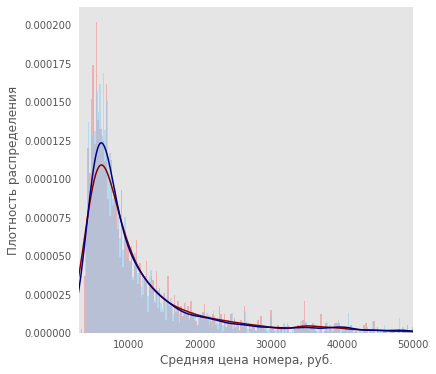

In [258]:
price_main = df_all_1['price_x']
rest = d[~d.isin(df_all_1)].dropna()
price_rest = rest['price']
fig, ax = plt.subplots(figsize = (6,6))

# Plot
    # Plot histogram
price_main.plot(kind = "hist", density = True, alpha = 0.5, bins = 200, color = 'lightcoral') # change density to true, because KDE uses density
    # Plot KDE
price_main.plot(kind = "kde", color = 'maroon')

price_rest.plot(kind = "hist", density = True, alpha = 0.5, bins = 200, color = 'lightskyblue') # change density to true, because KDE uses density
    # Plot KDE
price_rest.plot(kind = "kde", color = 'navy')


# X
ax.set_xlabel("Средняя цена номера, руб.")
    # Limit x range to 0-4
x_start, x_end = 3000, 50000
ax.set_xlim(x_start, x_end)

# Y
# ax.set_ylim(0, 0.00056)
# ax.set_yticklabels([])
ax.set_ylabel("Плотность распределения")

# Overall
ax.grid(False)

# Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
    
plt.show()

# удалим выбросы - номера с ценами выше 50к за ночь, но сделаем это до создания отдельных датасетов под тест и трейн для классификации

### 3. LATE-разметка
1 Always-takers $P_{Booking}$=$P_{min}$=$P_{Agoda}$

2 Compliers $P_{Booking}$>$P_{min}$=$P_{Agoda}$

3 Never-takers $P_{Booking}$>$P_{min}$ & $P_{Agoda}$>$P_{min}$

4 Defiers $P_{Agoda}$>$P_{min}$=$P_{Booking}$

In [61]:
d.shape

(14956, 44)

In [62]:
# разобьем на отдельные датасеты все страты
df_elite = d[d['elite']==1]
df_business = d[d['business']==1]
df_comfort = d[d['comfort']==1]
df_economy = d[d['economy']==1]
print(df_elite.shape,
      df_business.shape,
      df_comfort.shape,
      df_economy.shape,
     )

(2334, 44) (1299, 44) (6339, 44) (4984, 44)


In [63]:
def late_prep(data):
    # а затем в рамках каждой страты удалим наблюдения по отелям, где нет предложений ни на Booking'e, ни на Agod'e
    # создадим переменную, которая будет равна мин цене по каждому отелю
    data = data.merge(data.groupby('hotel_name')['price'].agg('min'), right_index=True, left_on='hotel_name')
    # создали флаг для случая, если цена минимальна на данной платформе
    data['min_price'] =  np.where((data['price_x']==data['price_y']), 1, 0)    
    #  выкидываем лишние, оставляем только номера с платформами агода и|или букинг
    data = data.loc[(data['provider_name'] == 'Agoda.com') | (data['provider_name'] == 'Booking.com')]
    
    # создадим дамми для обозначения, что у отеля(!) есть предложения на Booking'e/Agod'e 
    data['Agoda'] =  np.where(( (data['provider_name']=='Agoda.com') ), 1, 0)
    data['A'] = data['Agoda'].groupby(data['hotel_name']).transform('sum')
    data['A'] = np.where(( (data['A']>=1) ), 1, 0)
    data['Booking'] =  np.where(( (data['provider_name']=='Booking.com') ), 1, 0)
    data['B'] = data['Booking'].groupby(data['hotel_name']).transform('sum')
    data['B'] = np.where(( (data['B']>=1) ), 1, 0)
    # создадим дамми, которая будет указывать на то, что для данного отеля есть предложения и на Agod'e, и на Booking'e
    data['A_and_B'] = data['A']*data['B']

    # разметим тритменты для тех отелей, где есть предложения и на агоде, и на букинге, остальные забьем 999
    
    # создали дамми для случая, если цена минимальна на агоде
    data['min_price_Agoda'] = np.nan
    data['T_Agoda'] = np.nan
    data['T_Agoda'][data['A'] == 0] = 999
    data['min_price_Agoda'][data['A'] != 0] =  np.where(( (data['min_price']==1) & 
                                                          (data['provider_name']=='Agoda.com') ), 1, 0)
    data['T_Agoda'][data['A'] != 0] = data['min_price_Agoda'].groupby(data['hotel_name']).transform('sum')
    data['T_Agoda'][data['A'] != 0] = np.where(( (data['T_Agoda']>=1) ), 1, 0)

    # создали дамми для случая, если цена минимальна на букинге
    data['min_price_Booking'] = np.nan
    data['T_Booking'] = np.nan
    data['T_Booking'][data['B'] == 0] = 999
    data['min_price_Booking'][data['B'] != 0] =  np.where(( (data['min_price']==1) & 
                                                            (data['provider_name']=='Booking.com') ), 1, 0)
    data['T_Booking'][data['B'] != 0] = data['min_price_Booking'].groupby(data['hotel_name']).transform('sum')
    data['T_Booking'][data['B'] != 0] = np.where(( (data['T_Booking']>=1) ), 1, 0)
    
    return(data)

In [64]:
df_join = [df_elite, df_business, df_comfort, df_economy]
kolhoz = []
for i in range(4):
    df_join[i] = late_prep(df_join[i])
    kolhoz.append(len(df_join[i][(df_join[i]['T_Agoda'] == 999) | (df_join[i]['T_Booking'] == 999)])/len(df_join[i]))
    print(i, 'is ready')

0 is ready
1 is ready
2 is ready
3 is ready


In [829]:
# i=3
# df_join[i][(df_join[i]['A'] == 1) & (df_join[i]['B'] == 0) & (df_join[i]['min_price'] == 1)]

In [65]:
# у нас были наблюдения, для которых нет предложения на агоде или на букинге
# поэтому заполним округленным средним значением тритмента
def preliminary_stage(df_join):
    el = df_join[0].copy()
    bu = df_join[1].copy()
    com = df_join[2].copy()
    ec = df_join[3].copy()
    df = [el, bu, com, ec]
    for i in range(4):
        df[i] = df[i][(df[i]['T_Agoda'] != 999)]
        df[i] = df[i].loc[(df[i]['provider_name'] == 'Agoda.com') | 
                          (df[i]['provider_name'] == 'Booking.com')].groupby('hotel_name').filter(lambda x: any(x['provider_name'] == 'Agoda.com') &
                                                                                                            any(x['provider_name'] == 'Booking.com'))
    df_pre_1 = pd.concat([df[0], df[1], df[2], df[3]])
    mean_A_2 = round(df_pre_1['T_Agoda'].mean())

    el = df_join[0].copy()
    bu = df_join[1].copy()
    com = df_join[2].copy()
    ec = df_join[3].copy()
    df = [el, bu, com, ec]
    for i in range(4):
        df[i] = df[i][(df[i]['T_Booking'] != 999)]
        df[i] = df[i].loc[(df[i]['provider_name'] == 'Agoda.com') | 
                          (df[i]['provider_name'] == 'Booking.com')].groupby('hotel_name').filter(lambda x: any(x['provider_name'] == 'Agoda.com') &
                                                                                                            any(x['provider_name'] == 'Booking.com'))
    df_pre_2 = pd.concat([df[0], df[1], df[2], df[3]])
    mean_B_2 = round(df_pre_2['T_Booking'].mean())

    df_all_2 = pd.concat([df_join[0], df_join[1], df_join[2], df_join[3]])
    df_all_2['T_Agoda'][df_all_2['T_Agoda']==999] = mean_A_2
    df_all_2['T_Booking'][df_all_2['T_Booking']==999] = mean_B_2
    # снова разделяем на датафреймы по стратам, чтобы дальше сделать разметку
    df_elite = df_all_2[df_all_2['elite']==1]
    df_business = df_all_2[df_all_2['business']==1]
    df_comfort = df_all_2[df_all_2['comfort']==1]
    df_economy = df_all_2[df_all_2['economy']==1]
    return(df_elite, df_business, df_comfort, df_economy)

In [66]:
%%time
df_elite, df_business, df_comfort, df_economy = preliminary_stage(df_join)

Wall time: 449 ms


In [835]:
# df_elite[df_elite['T_Agoda']==999]

In [67]:
def late(data):
    # устанавливаем флаг на always-taker'ов, где выполнены оба условия, т.е. сумма флагов по каждому отелю не менее 2-ух
    data['always_taker'] =  np.where(( (data['T_Agoda'] == 1) &
                                       (data['T_Booking'] == 1)), 1, 0)
    # устанавливаем флаг на complier'ов, где выполнены все условия
    data['complier'] =  np.where(( (data['T_Agoda'] == 1) &
                                   (data['T_Booking'] == 0) ), 1, 0)    
    # устанавливаем флаг на never-taker'ов, где выполнены все условия
    data['never_taker'] =  np.where(( (data['T_Agoda'] == 0) &
                                      (data['T_Booking'] == 0) ), 1, 0)    
    # устанавливаем флаг на defier'ов, где выполнены все условия
    data['defier'] =  np.where(( (data['T_Agoda'] == 0) &
                                 (data['T_Booking'] == 1)), 1, 0)
    return(data)

In [195]:
%%time
df_join = [df_elite, df_business, df_comfort, df_economy]

ate_dre_4 = []

for i in range(4):
# #       LATE-разметка 
    df_join[i] = late(df_join[i])
    #       Double Robust Estimation
    ate_dre = double_robust(df_join[i], y_prob0, y_prob1)
    ate_dre_4.append(ate_dre)

ate_dr = (ate_dre_4[0]*len(df_elite) + ate_dre_4[1]*len(df_business) + ate_dre_4[2]*len(df_comfort) + ate_dre_4[3]*len(df_economy))/(len(df_elite) + len(df_business) + len(df_comfort) + len(df_economy))
# ate_dre_2.append(ate_dr) 
# ate_dre_2_elite.append(ate_dre_4[0])
# ate_dre_2_business.append(ate_dre_4[1])
# ate_dre_2_comfort.append(ate_dre_4[2])
# ate_dre_2_economy.append(ate_dre_4[3])
    

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


ValueError: Length of values (513) does not match length of index (757)

In [864]:
ate_pwb_4

[-18769.971740370805,
 -20212.94156299285,
 -11192.382019958783,
 -7519.84496900546]

#### Baseline efffect (simple difference in means)  
$$ E[Y \mid T=1]-E[Y \mid T=0] $$

In [169]:
smf.ols("price_x ~  always_taker ", data=block_AT_D_2).fit().summary()
smf.ols("price_x ~  always_taker + stars + feedback_count + elite + business + comfort + economy + rubbish + rating_overall + rating_address + rating_value_for_money + rating_room_quality + rating_equip + rating_cleanliness + rating_services + non_refundable_dummy + free_cancellation_dummy + free_breakfast_dummy + pay_at_hotel_dummy + non_smoking_dummy + free_internet_dummy + pets_dummy + summary_1 + summary_2 + summary_3 + summary_4 + summary_5 + leisure_1 + leisure_2 + leisure_3 + leisure_4 + leisure_5 + service_1 + service_2 + service_3 + service_4 + service_5 + r_eq_with_1 + r_eq_with_2 + r_eq_with_3 + r_eq_with_4 + r_eq_with_5 + A + B + min_price", data=block_AT_D_2).fit().summary()
smf.ols("price_x ~  always_taker + stars + feedback_count + apartment + villa + family + junior_suite + suite + standard + rub + rub_rub + rating_overall + rating_address + rating_value_for_money + rating_room_quality + rating_equip + rating_cleanliness + rating_services + non_refundable_dummy + free_cancellation_dummy + free_breakfast_dummy + pay_at_hotel_dummy + non_smoking_dummy + free_internet_dummy + pets_dummy + summary_1 + summary_2 + summary_3 + summary_4 + summary_5 + leisure_1 + leisure_2 + leisure_3 + leisure_4 + leisure_5 + service_1 + service_2 + service_3 + service_4 + service_5 + r_eq_with_1 + r_eq_with_2 + r_eq_with_3 + r_eq_with_4 + r_eq_with_5 + A + B + min_price", data=block_AT_D_2).fit().summary()
# нет ли эндогенности по размещению на платформах: может быть, высокая цена связана с тем, что цена именно на Агоде выше?
# Ответ: нет, значимый прирост цены на Агоде по сравнению с Букингом объяснен, признак отсутствия omitted variable bias
# нет фиксированнного эффекта модели
# эффект тритмента значимый
# мусорные переменные незначимы, значит, колхозная стратификация довольно неплоха


# не работает объяснение, так как переменная агоды значима и имеет отрицательный коэф-т, то есть факт присутствия на агоде
# в среднем цену снижает, а не повышает, несмотря на паритет и факт комиссии
# платформа менее популярная, может, поэтому
# если гнать то же самое по блокам с букингом, то переменная букинга значима и положительна

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                price_x   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     45.85
Date:                Tue, 10 May 2022   Prob (F-statistic):          4.21e-213
Time:                        00:24:59   Log-Likelihood:                -10894.
No. Observations:                1085   AIC:                         2.188e+04
Df Residuals:                    1039   BIC:                         2.211e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                3545.5488   2694.690      1.316      0.189   -1742.106    8833.204
always_taker             4281.5941   1183.441      3.618      0.000    1959.387    6603.802
stars                    4490.8634    529.572      8.480      0.000    3451.712    5530.015
feedback_count             -1.0728      0.111     -9.688      0.000      -1.290      -0.855
apartment                1198.5401    778.323      1.540      0.124    -328.723    2725.804
villa                    3405.6536   1966.221      1.732      0.084    -452.564    7263.871
family                   2952.6829   1078.379      2.738      0.006     836.635    5068.731
junior_suite            -1451.5561    688.862     -2.107      0.035   -2803.276     -99.837
suite                    1044.2463    708.222      1.474      0.141    -345.461    2433.954
standard                -3604.0179    661.192     -5.451      0.000   -4901.442   -2306.594
rub                     -1252.8242    493.659     -2.538      0.011   -2221.507    -284.141
rub_rub                 -1601.5807   1007.062     -1.590      0.112   -3577.687     374.526
rating_overall           3.518e+04   3716.872      9.464      0.000    2.79e+04    4.25e+04
rating_address           -914.8597    581.417     -1.574      0.116   -2055.744     226.025
rating_value_for_money  -1.397e+04   1022.921    -13.658      0.000    -1.6e+04    -1.2e+04
rating_room_quality     -1030.9765    213.694     -4.825      0.000   -1450.297    -611.656
rating_equip             1106.1511    358.934      3.082      0.002     401.832    1810.470
rating_cleanliness      -1.738e+04   1934.934     -8.983      0.000   -2.12e+04   -1.36e+04
rating_services         -4761.5349   3044.863     -1.564      0.118   -1.07e+04    1213.248
non_refundable_dummy      192.9981    605.355      0.319      0.750    -994.860    1380.856
free_cancellation_dummy  -371.0111    681.683     -0.544      0.586   -1708.643     966.621
free_breakfast_dummy      827.0244    444.772      1.859      0.063     -45.730    1699.779
pay_at_hotel_dummy       -720.3681    615.354     -1.171      0.242   -1927.846     487.110
non_smoking_dummy       -1526.1059   1407.435     -1.084      0.278   -4287.846    1235.634
free_internet_dummy      3545.5488   2694.690      1.316      0.189   -1742.106    8833.204
pets_dummy               1059.0451    459.390      2.305      0.021     157.606    1960.484
summary_1                 1.85e+04   1.37e+04      1.349      0.178   -8405.067    4.54e+04
summary_2                4.179e+04   3.11e+04      1.345      0.179   -1.92e+04    1.03e+05
summary_3               -5.033e+04   2.72e+04     -1.854      0.064   -1.04e+05    2951.396
summary_4               -8.186e+04   2.32e+04     -3.523      0.000   -1.27e+05   -3.63e+04
summary_5               -5.694e+04   1.36e+04  

In [170]:
# проверка того, что A и B, если не включать platform-specific фичи, перетянут звездочки (объясненную дисперсию)
smf.ols("price_x ~  stars + feedback_count + elite + business + comfort + economy + rubbish + rating_overall + rating_address + rating_value_for_money + rating_room_quality + rating_equip + rating_cleanliness + rating_services + non_smoking_dummy + free_internet_dummy + pets_dummy + summary_1 + summary_2 + summary_3 + summary_4 + summary_5 + leisure_1 + leisure_2 + leisure_3 + leisure_4 + leisure_5 + service_1 + service_2 + service_3 + service_4 + service_5 + r_eq_with_1 + r_eq_with_2 + r_eq_with_3 + r_eq_with_4 + r_eq_with_5 + A + B", data=block_AT_D_2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                price_x   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     50.82
Date:                Tue, 10 May 2022   Prob (F-statistic):          4.16e-202
Time:                        00:43:07   Log-Likelihood:                -10939.
No. Observations:                1085   AIC:                         2.195e+04
Df Residuals:                    1048   BIC:                         2.214e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1794.2000   2719.436      0.660      0.510   -3541.959    7130.359
stars                   4239.4406    539.155      7.863      0.000    3181.495    5297.386
feedback_count            -1.0584      0.112     -9.431      0.000      -1.279      -0.838
elite                   3557.7311    782.106      4.549      0.000    2023.059    5092.403
business                -670.0967    938.344     -0.714      0.475   -2511.344    1171.150
comfort                 1160.0802    708.932      1.636      0.102    -231.008    2551.169
economy                -2253.5146    797.586     -2.825      0.005   -3818.562    -688.467
rubbish                -4110.5405    791.316     -5.195      0.000   -5663.284   -2557.797
rating_overall          3.314e+04   3686.435      8.990      0.000    2.59e+04    4.04e+04
rating_address           -38.6984    587.632     -0.066      0.948   -1191.767    1114.370
rating_value_for_money -1.518e+04   1050.120    -14.453      0.000   -1.72e+04   -1.31e+04
rating_room_quality    -1002.6272    208.181     -4.816      0.000   -1411.126    -594.128
rating_equip            1126.9569    350.803      3.213      0.001     438.600    1815.313
rating_cleanliness     -1.878e+04   1979.084     -9.488      0.000   -2.27e+04   -1.49e+04
rating_services         -791.7799   3016.415     -0.262      0.793   -6710.681    5127.121
non_smoking_dummy      -2597.5470   1415.843     -1.835      0.067   -5375.756     180.663
free_internet_dummy     1794.2000   2719.436      0.660      0.510   -3541.959    7130.359
pets_dummy              1055.9321    465.458      2.269      0.023     142.596    1969.268
summary_1               7197.7442   1.38e+04      0.521      0.603   -1.99e+04    3.43e+04
summary_2               6.057e+04   3.18e+04      1.905      0.057   -1820.291    1.23e+05
summary_3              -3.752e+04   2.77e+04     -1.353      0.176   -9.19e+04    1.69e+04
summary_4              -5.832e+04   2.33e+04     -2.502      0.013   -1.04e+05   -1.26e+04
summary_5              -5.314e+04    1.4e+04     -3.789      0.000   -8.07e+04   -2.56e+04
leisure_1               1.387e+04   1.46e+04      0.947      0.344   -1.49e+04    4.26e+04
leisure_2              -3054.6026   1.38e+04     -0.221      0.825   -3.01e+04     2.4e+04
leisure_3               5.596e+04   1.69e+04      3.302      0.001    2.27e+04    8.92e+04
leisure_4              -9.676e+04   1.37e+04     -7.064      0.000   -1.24e+05   -6.99e+04
leisure_5               1.835e+04   6813.005      2.694      0.007    4985.940    3.17e+04
service_1               3.311e+05   5.79e+04      5.724      0.000    2.18e+05    4.45e+05
service_2              -2.637e+05   5.16e+04     -5.113      0.000   -3.65e+05   -1.63e+05
service_3              -2.326e+04    3.9e+04     -0.597      0.551   -9.97e+04  

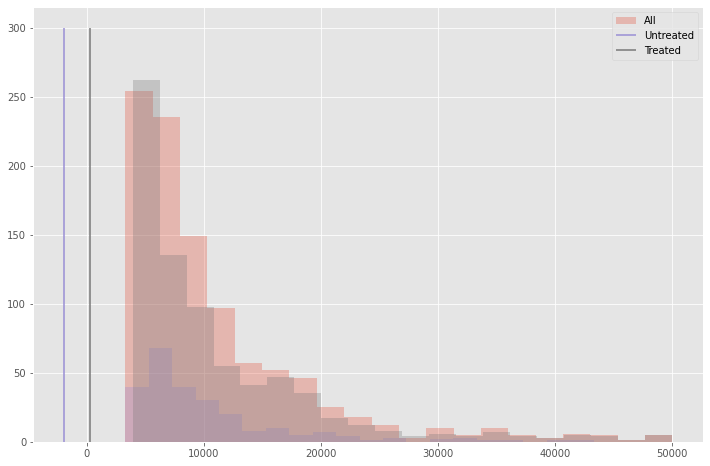

In [2369]:
# график плотности цен для тритмента и контроля
plt.hist(block_AT_C_2["price_x"], bins=20, alpha=0.3, label="All")
plt.hist(block_AT_C_2.query("T_Booking==0")["price_x"], bins=20, alpha=0.3, color="C2")
plt.hist(block_AT_C_2.query("T_Booking==1")["price_x"], bins=20, alpha=0.3, color="C3")
plt.vlines(-1983.5652, 0, 300, label="Untreated", color="C2")
plt.vlines(-1983.5652+2278.9501, 0, 300, label="Treated", color="C3")
plt.legend();

#### 4.  Propensity score estimation 

#### Interaction terms and covariates choice

In [68]:
# выберем базовые ковариаты и зависимую переменную
# # первый блок, вторая классификация 
def data_engin_2(data1, data2):
    data1 = block_AT_D_2
    X0 = block_AT_D_2.drop(['hotel_name', 'provider_name', 
                           'price_x', 'price_y', 
                           'T_Agoda', 'T_Booking',
#                            'apartment', 'villa', 'family', 'junior_suite', 'suite', 'standard',
#                            'rub', 'rub_rub',
                           'Agoda', 'Booking', 'A_and_B', 
                           'min_price', 'min_price_Agoda', 'min_price_Booking',
                           'always_taker', 'complier', 'never_taker', 'defier'
#                             ,
#                            'strata_2'
                           ], axis=1).copy()
    y0 = block_AT_D_2['T_Agoda'].copy()

# создадим interaction terms для страт и других переменных
#     stratas = X0[['elite', 'business', 'comfort', 'economy']]
#     stratas_plus = X0[['elite', 'business', 'comfort', 'economy', 'rubbish']]
#     to_multiply_with = X0.drop(stratas_plus, axis=1)

#     for i in range(4):
#         for j in range(38):
#             X0 = X0.copy()
#             col1 = str(stratas.columns[i])
#             col2 = str(to_multiply_with.columns[j])
#             name = col1 + "_x_" + col2 
#             X0[name] = pd.Series(stratas[col1] * to_multiply_with[col2], name=name)
#################################################################################
# # второй блок, вторая классификация 
    data2 = block_NT_C_2
    X1 = block_NT_C_2.drop(['hotel_name', 'provider_name', 
                           'price_x', 'price_y', 
                           'T_Agoda', 'T_Booking',
#                            'apartment', 'villa', 'family', 'junior_suite', 'suite', 'standard',
#                            'rub', 'rub_rub',
                           'Agoda', 'Booking', 'A_and_B', 
                           'min_price', 'min_price_Agoda', 'min_price_Booking',
                           'always_taker', 'complier', 'never_taker', 'defier'
#                             ,
#                            'strata_2'
                           ], axis=1).copy()
    y1 = block_NT_C_2['T_Agoda'].copy()
# создадим interaction terms для страт и других переменных
#     stratas = X1[['elite', 'business', 'comfort', 'economy']]
#     stratas_plus = X1[['elite', 'business', 'comfort', 'economy', 'rubbish']]
#     to_multiply_with = X1.drop(stratas_plus, axis=1)

#     for i in range(4):
#         for j in range(38):
#             X1 = X1.copy()
#             col1 = str(stratas.columns[i])
#             col2 = str(to_multiply_with.columns[j])
#             name = col1 + "_x_" + col2 
#             X1[name] = pd.Series(stratas[col1] * to_multiply_with[col2], name=name)
    
    return(X0, y0, X1, y1)

In [323]:
# X0, y0, X1, y1 = data_engin_1(block_AT_D_1, block_NT_C_1)

#### Propensity score estimation

In [173]:
def prop_score_estimation(X0,y0,X1,y1):
#     model0 = LogisticRegressionCV(Cs=np.linspace(0.001, 100, num=50), cv=5, penalty='l1', 
#                                   class_weight='balanced', max_iter=250, 
#                                   refit=True, scoring='roc_auc', 
#                                   solver='saga', random_state=42, 
#                                   n_jobs=-1, verbose=0).fit(X0, y0)
#     y_pred0 = model0.predict(X0)
#     y_prob0 = model0.predict_proba(X0)
# #     roc_auc0 = model0.score(X0, y0)

#     model1 = LogisticRegressionCV(Cs=np.linspace(0.001, 100, num=50), cv=5, penalty='l1', 
#                                   class_weight='balanced', max_iter=250, 
#                                   refit=True, scoring='roc_auc', 
#                                   solver='saga', random_state=42, 
#                                   n_jobs=-1, verbose=0).fit(X1, y1)
#     y_pred1 = model1.predict(X1)
#     y_prob1 = model1.predict_proba(X1)
# #     roc_auc1 = model1.score(X1, y1)

    cs = np.linspace(0.001, 100, num=5)
    score = []
    for c in cs:
        model0 = SVC(C=c, kernel='rbf', gamma='scale', 
                 probability=True, class_weight='balanced', random_state=42).fit(X0, y0)
        y_pred0 = model0.predict(X0)
        y_prob0 = model0.predict_proba(X0)
    #     print(model0.score(X0, y0))
        score.append(model0.score(X0, y0))
    for i in range(len(score)):
        if score[i] == max(score):
            model0 = SVC(C=cs[i], kernel='rbf', gamma='scale', 
                         probability=True, class_weight='balanced', random_state=42).fit(X0, y0)
            y_pred0 = model0.predict(X0)
            y_prob0 = model0.predict_proba(X0)
    #     print(model0.score(X0, y0))
        else:
            pass
    # print(model0.score(X0, y0))

    score = [] 
    for c in cs:
        model1 = SVC(C=c, kernel='rbf', gamma='scale', 
                 probability=True, class_weight='balanced', random_state=42).fit(X1, y1)
        y_pred1 = model1.predict(X1)
        y_prob1 = model1.predict_proba(X1)
    #     print(model1.score(X1, y1))
        score.append(model1.score(X1, y1))
    for i in range(len(score)):
        if score[i] == max(score):
            model1 = SVC(C=cs[i], kernel='rbf', gamma='scale', 
                         probability=True, class_weight='balanced', random_state=42).fit(X1, y1)
            y_pred1 = model1.predict(X1)
            y_prob1 = model1.predict_proba(X1)
    #         print(model1.score(X1, y1))
        else:
            pass
    # print(model1.score(X1, y1))
    
    return(y_pred0, y_prob0, y_pred1, y_prob1)

In [172]:
# %%time
# # from sklearn.svm import SVC
# cs = np.linspace(0.001, 100, num=5)
# score = []
# for c in cs:
#     model0 = SVC(C=c, kernel='rbf', gamma='scale', 
#              probability=True, class_weight='balanced', random_state=42).fit(X0, y0)
#     y_pred0 = model0.predict(X0)
#     y_prob0 = model0.predict_proba(X0)
# #     print(model0.score(X0, y0))
#     score.append(model0.score(X0, y0))
# for i in range(len(score)):
#     if score[i] == max(score):
#         model0 = SVC(C=cs[i], kernel='rbf', gamma='scale', 
#                      probability=True, class_weight='balanced', random_state=42).fit(X0, y0)
#         y_pred0 = model0.predict(X0)
#         y_prob0 = model0.predict_proba(X0)
# #     print(model0.score(X0, y0))
#     else:
#         pass
# # print(model0.score(X0, y0))

# score = [] 
# for c in cs:
#     model1 = SVC(C=c, kernel='rbf', gamma='scale', 
#              probability=True, class_weight='balanced', random_state=42).fit(X1, y1)
#     y_pred1 = model1.predict(X1)
#     y_prob1 = model1.predict_proba(X1)
# #     print(model1.score(X1, y1))
#     score.append(model1.score(X1, y1))
# for i in range(len(score)):
#     if score[i] == max(score):
#         model1 = SVC(C=cs[i], kernel='rbf', gamma='scale', 
#                      probability=True, class_weight='balanced', random_state=42).fit(X1, y1)
#         y_pred1 = model1.predict(X1)
#         y_prob1 = model1.predict_proba(X1)
# #         print(model1.score(X1, y1))
#     else:
#         pass
# # print(model1.score(X1, y1))
# # svc = SVC()
# # random_grid = {'C': np.linspace(0.001, 10, num=5),
# #                'kernel': ['rbf'],
# #                'gamma': ['scale'],
# #                'class_weight': ['balanced'],
# #                'probability': [True]}
# # model0 = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, n_iter = 5,
# #                             cv = 5, verbose=1, random_state=42, n_jobs = -1).fit(X0, y0)
# # y_pred0 = model0.predict(X0)
# # y_prob0 = model0.predict_proba(X0)

# # model1 = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, n_iter = 5,
# #                             cv = 5, verbose=1, random_state=42, n_jobs = -1).fit(X1, y1)
# # y_pred1 = model1.predict(X1)
# # y_prob1 = model1.predict_proba(X1)
# # print(model0.score(X0, y0))
# # print(model1.score(X1, y1))


0.6845493562231759
0.8790849673202614
Wall time: 6.23 s


In [ ]:
# y_pred0, y_prob0, y_pred1, y_prob1 = prop_score_estimation(X0,y0,X1,y1)

#### ROC-AUC, confusion matrix

In [189]:
# def classification_metrics(true, pred, prob=None, plot=False):    
#     if plot:
#         assert prob is not None, 'prob should be non-None'
#         plt.figure(0, (6, 6))
#         fpr, tpr, _ = roc_curve(true, prob[:, 1])
#         plt.plot(fpr, tpr)
#         plt.plot([0, 1], [0, 1], ls='--', label='random choice')
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('ROC-curve')
#         plt.legend()
#         plt.show()

In [1987]:
# plt.figure(figsize=(5,5))
# # # from sklearn import metrics
# # # from sklearn.metrics import RocCurveDisplay
# # # metrics.plot_roc_curve(model, X, y) 
# RocCurveDisplay.from_estimator(model1, X, y)
# plt.show()

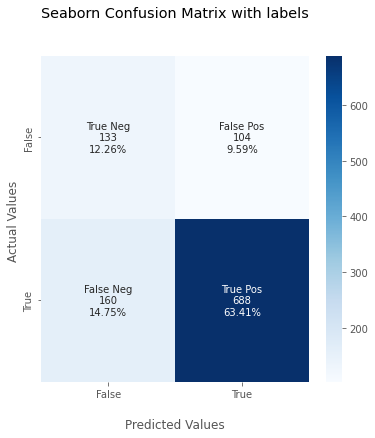

In [190]:
# sklearn.metrics.confusion_matrix
cf_matrix0 = confusion_matrix(y0, y_pred0)
# print(confusion_matrix(y1, y_pred1))
# import seaborn as sns
plt.figure(0, (6, 6))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix0.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix0.flatten()/np.sum(cf_matrix0)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix0, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

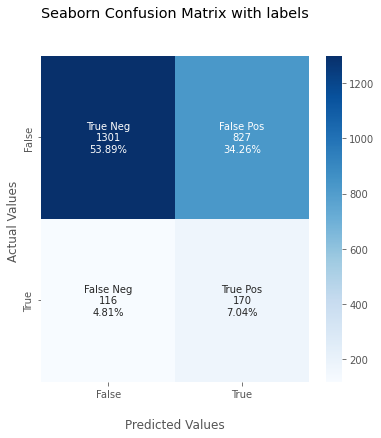

In [191]:
cf_matrix1 = confusion_matrix(y1, y_pred1)
# print(confusion_matrix(y1, y_pred1))
# import seaborn as sns
plt.figure(0, (6, 6))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix1.flatten()/np.sum(cf_matrix1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix1, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

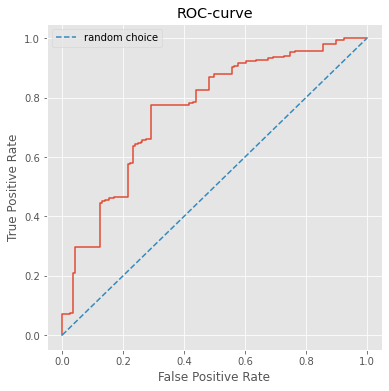

0.7587224345195446


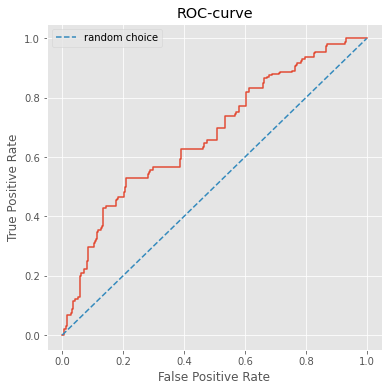

0.6723276723276723


In [192]:
classification_metrics(y0, y_pred0, y_prob0, plot = True)
print(roc_auc0)
classification_metrics(y1, y_pred1, y_prob1, plot = True)
print(roc_auc1)

#### Propensity weighting blocking estimation

In [70]:
def prop_weighting_blocking(block_AT_D_2, y_prob0, block_NT_C_2, y_prob1):
    
#     data1 = block_AT_D_2
    block_AT_D_2 = block_AT_D_2.assign(propensity_score=y_prob0[:, 1])
    weight_t1 = 1/block_AT_D_2.query("T_Agoda==1")["propensity_score"]
    weight_nt1 = 1/(1-block_AT_D_2.query("T_Agoda==0")["propensity_score"])
    weight1 = ((block_AT_D_2["T_Agoda"]-block_AT_D_2["propensity_score"]) /
              (block_AT_D_2["propensity_score"]*(1-block_AT_D_2["propensity_score"])))
    Y1_1 = sum(block_AT_D_2.query("T_Agoda==1")["price_x"]*weight_t1) / len(block_AT_D_2)
    Y0_1 = sum(block_AT_D_2.query("T_Agoda==0")["price_x"]*weight_nt1) / len(block_AT_D_2)
    ate_1 = np.mean(weight1 * block_AT_D_2["price_x"])
    
#     data2 = block_NT_C_2
    block_NT_C_2 = block_NT_C_2.assign(propensity_score=y_prob1[:, 1])    
    weight_t2 = 1/block_NT_C_2.query("T_Agoda==1")["propensity_score"]
    weight_nt2 = 1/(1-block_NT_C_2.query("T_Agoda==0")["propensity_score"])
    weight2 = ((block_NT_C_2["T_Agoda"]-block_NT_C_2["propensity_score"]) /
              (block_NT_C_2["propensity_score"]*(1-block_NT_C_2["propensity_score"])))
    Y1_2 = sum(block_NT_C_2.query("T_Agoda==1")["price_x"]*weight_t2) / len(block_NT_C_2)
    Y0_2 = sum(block_NT_C_2.query("T_Agoda==0")["price_x"]*weight_nt2) / len(block_NT_C_2)
    ate_2 = np.mean(weight2 * block_NT_C_2["price_x"])

    w1 = len(block_AT_D_2)
    w2 = len(block_NT_C_2)
    ate_pwb = ate_1*(w1/(w1+w2)) + ate_2*(w2/(w1+w2))
    
    return(ate_1, ate_2, ate_pwb)

#### Block 1

In [347]:
block_AT_D_2 = block_AT_D_2.assign(propensity_score=y_prob0[:, 1])
block_AT_D_2[["always_taker", "price_x", "propensity_score"]].head()

In [348]:
sns.histplot(block_AT_D_2.query("T_Agoda==0")["propensity_score"], color="lightcoral", label="Defiers", kde=False, stat="density")
sns.histplot(block_AT_D_2.query("T_Agoda==1")["propensity_score"], color="lightblue", label="Always-takers", kde=False, stat="density")
# plt.title('Positivity Check')
plt.suptitle('Positivity Check', fontsize=12)
plt.legend()

#### Block 2 

In [210]:
block_NT_C_2 = block_NT_C_2.assign(propensity_score=y_prob1[:, 1])
block_NT_C_2[["defier", "price_x", "propensity_score"]].head()

,defier,price_x,propensity_score
363,0,11880.0,0.000309
366,0,13200.0,0.000311
367,0,13500.0,0.000309
370,0,15000.0,0.000311
372,0,27000.0,0.000309


c:\users\евгеша\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


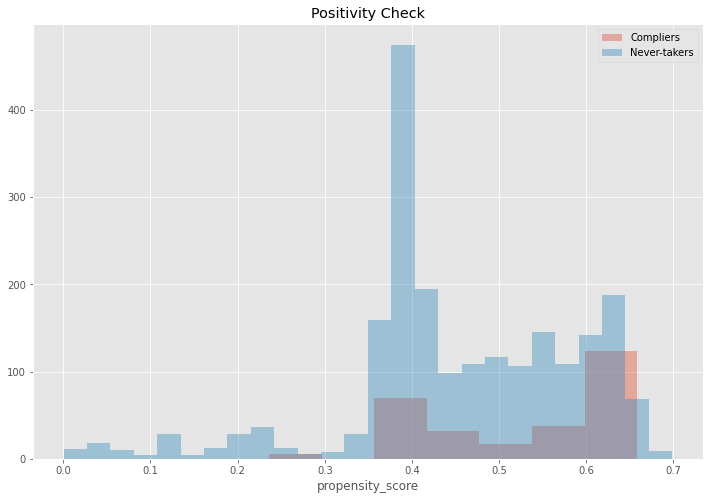

In [212]:
sns.distplot(block_NT_C_2.query("T_Agoda==1")["propensity_score"], kde=False, label="Compliers")
sns.distplot(block_NT_C_2.query("T_Agoda==0")["propensity_score"], kde=False, label="Never-takers")
plt.title("Positivity Check")
plt.legend();

#### Double Robust Estimation

In [1173]:
# %%time
# double = double_robust(df_join[0], y_prob0, y_prob1)
# df_join[0].shape
# kurtosis(df_join[0]['price_x']) 
# skew(df_join[0]['price_x'])
# st.mode(df_join[0]['price_x'])
# st.mode(df_join[0]['price_x'])

In [183]:
def double_robust(df, y_prob0, y_prob1):
    compliers = df[df['complier']==1]
    always_takers = df[df['always_taker']==1]
    never_takers = df[df['never_taker']==1]
    defiers = df[df['defier']==1]

    X_1 = compliers.drop(['hotel_name', 'provider_name', 
                         'price_x', 'price_y', 
                         'T_Agoda', 'T_Booking',
#                          'apartment', 'villa', 'family', 'junior_suite', 'suite', 'standard',
#                          'rub', 'rub_rub',
                         'Agoda', 'Booking', 'A_and_B', 
                         'min_price', 'min_price_Agoda', 'min_price_Booking',
                         'always_taker', 'complier', 'never_taker', 'defier'
#                           ,
#                          'strata_2'
                         ], axis=1).copy()
    y_1 = compliers['price_x'].copy()


    ##############################################################################################
    X_2 = always_takers.drop(['hotel_name', 'provider_name', 
                           'price_x', 'price_y', 
                           'T_Agoda', 'T_Booking',
#                            'apartment', 'villa', 'family', 'junior_suite', 'suite', 'standard',
#                            'rub', 'rub_rub',
                           'Agoda', 'Booking', 'A_and_B', 
                           'min_price', 'min_price_Agoda', 'min_price_Booking',
                           'always_taker', 'complier', 'never_taker', 'defier'
#                             ,
#                            'strata_2'
                             ], axis=1).copy()
    y_2 = always_takers['price_x'].copy()

    # ###################################################################################################
    X_3 = never_takers.drop(['hotel_name', 'provider_name', 
                           'price_x', 'price_y', 
                           'T_Agoda', 'T_Booking',
#                            'apartment', 'villa', 'family', 'junior_suite', 'suite', 'standard',
#                            'rub', 'rub_rub',
                           'Agoda', 'Booking', 'A_and_B', 
                           'min_price', 'min_price_Agoda', 'min_price_Booking',
                           'always_taker', 'complier', 'never_taker', 'defier'
#                              ,
#                            'strata_2'
                            ], axis=1).copy()
    y_3 = never_takers['price_x'].copy()

    ####################################################################################################
    X_4 = defiers.drop(['hotel_name', 'provider_name', 
                           'price_x', 'price_y', 
                           'T_Agoda', 'T_Booking',
#                            'apartment', 'villa', 'family', 'junior_suite', 'suite', 'standard',
#                            'rub', 'rub_rub',
                           'Agoda', 'Booking', 'A_and_B', 
                           'min_price', 'min_price_Agoda', 'min_price_Booking',
                           'always_taker', 'complier', 'never_taker', 'defier'
#                             ,
#                            'strata_2'
                            ], axis=1).copy()
    y_4 = defiers['price_x'].copy()

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
    # Number of features to consider at every split
    max_features = ['auto']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [3, 5]
    # Method of selecting samples for training each tree
    bootstrap = [True]

    etr = ExtraTreesRegressor()
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    # Random search of parameters, using 3 fold cross validation, 
    # search across 900 different combinations, and use all available cores
    etr_1 = RandomizedSearchCV(estimator = etr, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=1, random_state=42, n_jobs = -1).fit(X_1, y_1)
    etr_1_pred = etr_1.predict(X_1)
    etr_1_r_2 = etr_1.score(X_1,y_1)
    etr_1_best_params = etr_1.best_params_


    etr_2 = RandomizedSearchCV(estimator = etr, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=1, random_state=42, n_jobs = -1).fit(X_2, y_2)
    etr_2_pred = etr_2.predict(X_2)
    etr_2_r_2 = etr_2.score(X_2,y_2)
    etr_2_best_params = etr_2.best_params_


    etr_3 = RandomizedSearchCV(estimator = etr, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=1, random_state=42, n_jobs = -1).fit(X_3, y_3)
    etr_3_pred = etr_3.predict(X_3)
    etr_3_r_2 = etr_3.score(X_3,y_3)
    etr_3_best_params = etr_3.best_params_


    etr_4 = RandomizedSearchCV(estimator = etr, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=1, random_state=42, n_jobs = -1).fit(X_4, y_4)
    etr_4_pred = etr_4.predict(X_4)
    etr_4_r_2 = etr_4.score(X_4,y_4)
    etr_4_best_params = etr_4.best_params_
    
    ################################################
    

    mu1_1 = etr_2_pred #AT
    mu0_1 = etr_4_pred #D
    data_1 = df[df['T_Booking']==1]
    data_1['ps_1'] = y_prob0[:, 1]
    d1_1 = sum(data_1['price_x'][data_1['always_taker']==1]/data_1['ps_1'][data_1['always_taker']==1] - ((1 - data_1['ps_1'][data_1['always_taker']==1])*mu1_1/data_1['ps_1'][data_1['always_taker']==1]))/len(data_1[data_1['always_taker']==1])
    d2_1 = sum(data_1['price_x'][data_1['defier']==1]/(1 - data_1['ps_1'][data_1['defier']==1]) - (data_1['ps_1'][data_1['defier']==1]*mu0_1/(1 - data_1['ps_1'][data_1['defier']==1])))/len(data_1[data_1['defier']==1])
    dre_1 = d1_1 - d2_1

    
    mu1_2 = etr_1_pred #C
    mu0_2 = etr_3_pred #NT
    data_2 = df[df['T_Booking']==0]
    data_2['ps_2'] = y_prob1[:, 1]
    d1_2 = sum(data_2['price_x'][data_2['complier']==1]/data_2['ps_2'][data_2['complier']==1] - ((1 - data_2['ps_2'][data_2['complier']==1])*mu1_2/data_2['ps_2'][data_2['complier']==1]))/len(data_2[data_2['complier']==1])
    d2_2 = sum(data_2['price_x'][data_2['never_taker']==1]/(1 - data_2['ps_2'][data_2['never_taker']==1]) - (data_2['ps_2'][data_2['never_taker']==1]*mu0_2/(1 - data_2['ps_2'][data_2['never_taker']==1])))/len(data_2[data_2['never_taker']==1])
    dre_2 = d1_2 - d2_2

    w1 = len(data_1)
    w2 = len(data_2)
    dre = dre_1*(w1/(w1+w2)) + dre_2*(w2/(w1+w2))
    
    return(dre)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 5]
# Method of selecting samples for training each tree
bootstrap = [True]

etr = ExtraTreesRegressor()
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Random search of parameters, using 3 fold cross validation, 
# search across 900 different combinations, and use all available cores
etr_1 = RandomizedSearchCV(estimator = etr, param_distributions = random_grid, 
                           n_iter = 100, cv = 5, verbose=1, random_state=42, n_jobs = -1).fit(X_1, y_1)
etr_1_pred = etr_1.predict(X_1)
etr_1_r_2 = etr_1.score(X_1,y_1)
etr_1_best_params = etr_1.best_params_

In [2267]:
# print(*block_AT_C_2.columns, sep=' + ')

hotel_name + provider_name + price_x + stars + feedback_count + apartment + villa + family + junior_suite + suite + standard + rub + rub_rub + elite + business + comfort + economy + rubbish + rating_overall + rating_address + rating_value_for_money + rating_room_quality + rating_equip + rating_cleanliness + rating_services + non_refundable_dummy + free_cancellation_dummy + free_breakfast_dummy + pay_at_hotel_dummy + non_smoking_dummy + free_internet_dummy + pets_dummy + summary_1 + summary_2 + summary_3 + summary_4 + summary_5 + leisure_1 + leisure_2 + leisure_3 + leisure_4 + leisure_5 + service_1 + service_2 + service_3 + service_4 + service_5 + r_eq_with_1 + r_eq_with_2 + r_eq_with_3 + r_eq_with_4 + r_eq_with_5 + A + B + A_and_B + price_y + min_price + T_Agoda + T_Booking + always_taker + complier + never_taker + defier


#### Stratified bootstrap

In [199]:
# d.to_excel('data_for_bootstrap.xlsx')
d = pd.read_excel('data_for_bootstrap.xlsx')

In [203]:
d = d.drop(['Unnamed: 0'], axis=1)
dummies_2 = d[['elite', 'business', 'comfort', 'economy', 'rubbish']]
d['strata_2'] = pd.Series(dummies_2.columns[np.where(dummies_2!=0)[1]])
d['strata_2'] = d['strata_2'].map({'business': 1, 'elite': 2, 'economy': 3, 'comfort': 4, 'rubbish': 5})

In [205]:
d.shape

(14956, 45)

In [185]:
%%time

boot_2 = []
ate_naive_2 = [] # средневзвешенная по стратам блокинговая оценка
ate_naive_2_elite = [] # блокинг оценка по страте элит
ate_naive_2_business = [] # блокинг оценка по страте бизнес
ate_naive_2_comfort = [] # блокинг оценка по страте комфорт
ate_naive_2_economy = [] # блокинг оценка по страте эконом

ate_pwb_2 = [] # средневзвешенная по стратам блокинговая оценка
ate_pwb_2_elite = [] # блокинг оценка по страте элит
ate_pwb_2_business = [] # блокинг оценка по страте бизнес
ate_pwb_2_comfort = [] # блокинг оценка по страте комфорт
ate_pwb_2_economy = [] # блокинг оценка по страте эконом
# ate_AT_D_2 = []
# ate_NT_C_2 = []

# ate_dre_2 = []
# ate_dre_2_elite = []
# ate_dre_2_business = []
# ate_dre_2_comfort = []
# ate_dre_2_economy = []

strata_distr = []
late_distr = []
price_distr = []
artificial_treatment = []
for i in tqdm(range(10)):
    boot_sample = resample(d, n_samples=d.shape[0], replace=True, stratify=d['strata_2'])
    boot_2.append(boot_sample)
    
    df_elite = boot_2[i][boot_2[i]['elite']==1]
    df_business = boot_2[i][boot_2[i]['business']==1]
    df_comfort = boot_2[i][boot_2[i]['comfort']==1]
    df_economy = boot_2[i][boot_2[i]['economy']==1]
    
    df_join = [df_elite, df_business, df_comfort, df_economy]
    kolhoz = []
    for i in range(4):
        df_join[i] = late_prep(df_join[i])
        kolhoz.append(len(df_join[i][(df_join[i]['T_Agoda'] == 999) | (df_join[i]['T_Booking'] == 999)])/len(df_join[i]))
    artificial_treatment.append(kolhoz)
    # у нас были наблюдения, для которых нет предложения на агоде или на букинге
    # поэтому заполним округленным средним значением тритмента    
    df_elite, df_business, df_comfort, df_economy = preliminary_stage(df_join)

    df_join = [df_elite, df_business, df_comfort, df_economy]
    
    ate_AT_D_4 = []
    ate_NT_C_4 = []
    
    ate_naive_4 = []
    ate_pwb_4 = []
#     ate_dre_4 = []

    for i in range(4):
#       Naive Matching
        df_ = df_join[i].loc[(df_join[i]['provider_name'] == 'Agoda.com') | 
                             (df_join[i]['provider_name'] == 'Booking.com')].groupby('hotel_name').filter(lambda x: any(x['provider_name'] == 'Agoda.com') &
                                                                                                                    any(x['provider_name'] == 'Booking.com'))
        df_ = df_.groupby(['hotel_name', 'provider_name'], as_index=False).min()
        ate = []
        for i in range(0, len(df_['hotel_name']),  2):
            ate.append(df_['price_x'].iloc[i] - df_['price_x'].iloc[i+1])
        ate_naive = np.mean(ate)
        ate_naive_4.append(ate_naive)
        
    ate_naive = (ate_naive_4[0]*len(df_elite) + ate_naive_4[1]*len(df_business) + ate_naive_4[2]*len(df_comfort) + ate_naive_4[3]*len(df_economy))/(len(df_elite) + len(df_business) + len(df_comfort) + len(df_economy))
    ate_naive_2.append(ate_naive)
    ate_naive_2_elite.append(ate_naive_4[0])
    ate_naive_2_business.append(ate_naive_4[1])
    ate_naive_2_comfort.append(ate_naive_4[2])
    ate_naive_2_economy.append(ate_naive_4[3])
    
    for i in range(4):
# #       LATE-разметка 
        df_join[i] = late(df_join[i])
#       Propensity Weighting Blocking Estimation
        block_AT_D_2 = df_join[i][df_join[i]['T_Booking']==1]
        block_NT_C_2 = df_join[i][df_join[i]['T_Booking']==0]    
        X0, y0, X1, y1 = data_engin_2(block_AT_D_2, block_NT_C_2)
        y_pred0, y_prob0, y_pred1, y_prob1 = prop_score_estimation(X0, y0, X1, y1)
        ate_1, ate_2, ate_pwb = prop_weighting_blocking(block_AT_D_2, y_prob0, block_NT_C_2, y_prob1)
#         ate_AT_D_4.append(ate_1)
#         ate_NT_C_4.append(ate_2)
        ate_pwb_4.append(ate_pwb)
#       Double Robust Estimation
#         ate_dre = double_robust(df_join[i], y_prob0, y_prob1)
#         ate_dre_4.append(ate_dre)
    
    ate_pw = (ate_pwb_4[0]*len(df_elite) + ate_pwb_4[1]*len(df_business) + ate_pwb_4[2]*len(df_comfort) + ate_pwb_4[3]*len(df_economy))/(len(df_elite) + len(df_business) + len(df_comfort) + len(df_economy))
    ate_pwb_2.append(ate_pw) # средневзвешенная по стратам блокинговая оценка
    ate_pwb_2_elite.append(ate_pwb_4[0]) # блокинг оценка по страте элит
    ate_pwb_2_business.append(ate_pwb_4[1]) # блокинг оценка по страте бизнес
    ate_pwb_2_comfort.append(ate_pwb_4[2]) # блокинг оценка по страте комфорт
    ate_pwb_2_economy.append(ate_pwb_4[3]) # блокинг оценка по страте эконом
    
#     ate_dr = (ate_dre_4[0]*len(df_elite) + ate_dre_4[1]*len(df_business) + ate_dre_4[2]*len(df_comfort) + ate_dre_4[3]*len(df_economy))/(len(df_elite) + len(df_business) + len(df_comfort) + len(df_economy))
#     ate_dre_2.append(ate_dr) 
#     ate_dre_2_elite.append(ate_dre_4[0])
#     ate_dre_2_business.append(ate_dre_4[1])
#     ate_dre_2_comfort.append(ate_dre_4[2])
#     ate_dre_2_economy.append(ate_dre_4[3])
    
#     ate_AT_D_2.append(ate_AT_D_4)
#     ate_NT_C_2.append(ate_NT_C_4)
# ############ check-up распределения страт, лате и цен + наколхоженности тритментов
    df_all_2 = pd.concat([df_join[0], df_join[1], df_join[2], df_join[3]])
    late_distr.append([round(len(df_all_2[df_all_2['complier']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['always_taker']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['never_taker']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['defier']==1])/len(df_all_2)*100, 2)])
    strata_distr.append([round(len(df_all_2[df_all_2['elite']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['business']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['comfort']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['economy']==1])/len(df_all_2)*100, 2),
                      round(len(df_all_2[df_all_2['rubbish']==1])/len(df_all_2)*100, 2)])
    price_distr.append([round(kurtosis(df_all_2['price_x']),2), round(skew(df_all_2['price_x']),2), round(st.mode(df_all_2['price_x']),2)])

#         print(i, 'is ready')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:21<00:00, 20.14s/it]

Wall time: 3min 21s


In [188]:
late_distr

[[9.27, 12.56, 49.5, 28.67],
 [10.07, 10.85, 54.06, 25.03],
 [7.07, 12.7, 54.01, 26.23],
 [9.49, 13.01, 53.92, 23.58],
 [7.98, 12.05, 54.33, 25.63],
 [9.7, 10.56, 54.55, 25.19],
 [8.92, 11.64, 54.39, 25.04],
 [9.27, 10.63, 51.26, 28.84],
 [9.94, 12.46, 52.95, 24.66],
 [8.26, 12.47, 54.78, 24.49]]

In [193]:
%%time

boot_2 = []
# ate_naive_2 = [] # средневзвешенная по стратам блокинговая оценка
# ate_naive_2_elite = [] # блокинг оценка по страте элит
# ate_naive_2_business = [] # блокинг оценка по страте бизнес
# ate_naive_2_comfort = [] # блокинг оценка по страте комфорт
# ate_naive_2_economy = [] # блокинг оценка по страте эконом

# ate_pwb_2 = [] # средневзвешенная по стратам блокинговая оценка
# ate_pwb_2_elite = [] # блокинг оценка по страте элит
# ate_pwb_2_business = [] # блокинг оценка по страте бизнес
# ate_pwb_2_comfort = [] # блокинг оценка по страте комфорт
# ate_pwb_2_economy = [] # блокинг оценка по страте эконом

# ate_AT_D_2 = []
# ate_NT_C_2 = []

ate_dre_2 = []
ate_dre_2_elite = []
ate_dre_2_business = []
ate_dre_2_comfort = []
ate_dre_2_economy = []

strata_distr = []
late_distr = []
price_distr = []
artificial_treatment = []
for i in tqdm(range(1)):
    boot_sample = resample(d, n_samples=d.shape[0], replace=True, stratify=d['strata_2'])
    boot_2.append(boot_sample)
    
    df_elite = boot_2[i][boot_2[i]['elite']==1]
    df_business = boot_2[i][boot_2[i]['business']==1]
    df_comfort = boot_2[i][boot_2[i]['comfort']==1]
    df_economy = boot_2[i][boot_2[i]['economy']==1]
    
    df_join = [df_elite, df_business, df_comfort, df_economy]
    kolhoz = []
    for i in range(4):
        df_join[i] = late_prep(df_join[i])
        kolhoz.append(len(df_join[i][(df_join[i]['T_Agoda'] == 999) | (df_join[i]['T_Booking'] == 999)])/len(df_join[i]))
    artificial_treatment.append(kolhoz)
    # у нас были наблюдения, для которых нет предложения на агоде или на букинге
    # поэтому заполним округленным средним значением тритмента    
    df_elite, df_business, df_comfort, df_economy = preliminary_stage(df_join)
    df_join = [df_elite, df_business, df_comfort, df_economy]
    
#     ate_AT_D_4 = []
#     ate_NT_C_4 = []
    
#     ate_naive_4 = []
#     ate_pwb_4 = []
    ate_dre_4 = []

#     for i in range(4):
# #       Naive Matching
#         df_ = df_join[i].loc[(df_join[i]['provider_name'] == 'Agoda.com') | 
#                              (df_join[i]['provider_name'] == 'Booking.com')].groupby('hotel_name').filter(lambda x: any(x['provider_name'] == 'Agoda.com') &
#                                                                                                                     any(x['provider_name'] == 'Booking.com'))
#         df_ = df_.groupby(['hotel_name', 'provider_name'], as_index=False).min()
#         ate = []
#         for i in range(0, len(df_['hotel_name']),  2):
#             ate.append(df_['price_x'].iloc[i] - df_['price_x'].iloc[i+1])
#         ate_naive = np.mean(ate)
#         ate_naive_4.append(ate_naive)
        
#     ate_naive = (ate_naive_4[0]*len(df_elite) + ate_naive_4[1]*len(df_business) + ate_naive_4[2]*len(df_comfort) + ate_naive_4[3]*len(df_economy))/(len(df_elite) + len(df_business) + len(df_comfort) + len(df_economy))
#     ate_naive_2.append(ate_naive)
#     ate_naive_2_elite.append(ate_naive_4[0])
#     ate_naive_2_business.append(ate_naive_4[1])
#     ate_naive_2_comfort.append(ate_naive_4[2])
#     ate_naive_2_economy.append(ate_naive_4[3])
    
    for i in range(4):
# #       LATE-разметка 
        df_join[i] = late(df_join[i])
# #       Propensity Weighting Blocking Estimation
#         block_AT_D_2 = df_join[i][df_join[i]['T_Booking']==1]
#         block_NT_C_2 = df_join[i][df_join[i]['T_Booking']==0]    
#         X0, y0, X1, y1 = data_engin_2(block_AT_D_2, block_NT_C_2)
#         y_pred0, y_prob0, y_pred1, y_prob1 = prop_score_estimation(X0, y0, X1, y1)
#         ate_1, ate_2, ate_pwb = prop_weighting_blocking(block_AT_D_2, y_prob0, block_NT_C_2, y_prob1)
# #         ate_AT_D_4.append(ate_1)
# #         ate_NT_C_4.append(ate_2)
#         ate_pwb_4.append(ate_pwb)
#       Double Robust Estimation
        ate_dre = double_robust(df_join[i], y_prob0, y_prob1)
        ate_dre_4.append(ate_dre)
    
#     ate_pw = (ate_pwb_4[0]*len(df_elite) + ate_pwb_4[1]*len(df_business) + ate_pwb_4[2]*len(df_comfort) + ate_pwb_4[3]*len(df_economy))/(len(df_elite) + len(df_business) + len(df_comfort) + len(df_economy))
#     ate_pwb_2.append(ate_pw) # средневзвешенная по стратам блокинговая оценка
#     ate_pwb_2_elite.append(ate_pwb_4[0]) # блокинг оценка по страте элит
#     ate_pwb_2_business.append(ate_pwb_4[1]) # блокинг оценка по страте бизнес
#     ate_pwb_2_comfort.append(ate_pwb_4[2]) # блокинг оценка по страте комфорт
#     ate_pwb_2_economy.append(ate_pwb_4[3]) # блокинг оценка по страте эконом
    
    ate_dr = (ate_dre_4[0]*len(df_elite) + ate_dre_4[1]*len(df_business) + ate_dre_4[2]*len(df_comfort) + ate_dre_4[3]*len(df_economy))/(len(df_elite) + len(df_business) + len(df_comfort) + len(df_economy))
    ate_dre_2.append(ate_dr) 
    ate_dre_2_elite.append(ate_dre_4[0])
    ate_dre_2_business.append(ate_dre_4[1])
    ate_dre_2_comfort.append(ate_dre_4[2])
    ate_dre_2_economy.append(ate_dre_4[3])
    
#     ate_AT_D_2.append(ate_AT_D_4)
#     ate_NT_C_2.append(ate_NT_C_4)
# ############ check-up распределения страт, лате и цен + наколхоженности тритментов
    df_all_2 = pd.concat([df_join[0], df_join[1], df_join[2], df_join[3]])
    late_distr.append([round(len(df_all_2[df_all_2['complier']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['always_taker']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['never_taker']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['defier']==1])/len(df_all_2)*100, 2)])
    strata_distr.append([round(len(df_all_2[df_all_2['elite']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['business']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['comfort']==1])/len(df_all_2)*100, 2), 
                      round(len(df_all_2[df_all_2['economy']==1])/len(df_all_2)*100, 2),
                      round(len(df_all_2[df_all_2['rubbish']==1])/len(df_all_2)*100, 2)])
    price_distr.append([round(kurtosis(df_all_2['price_x']),2), round(skew(df_all_2['price_x']),2), round(st.mode(df_all_2['price_x']),2)])

#         print(i, 'is ready')

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


  0%|                                                                                            | 0/1 [04:53<?, ?it/s]


ValueError: Length of values (513) does not match length of index (757)

In [189]:
# strata_distr
# late_distr
# price_distr
# artificial_treatment
ate_pwb_2

[-1630.5856463817352,
 -1352.574524515571,
 -1075.3550185296472,
 -1485.3532116340746,
 -2583.0829762613876,
 -2563.348731958365,
 -1561.8055582914112,
 -1490.5252862827872,
 -2457.7886005297605,
 -1481.2140893914966]

In [190]:
estimations = {
               'ate_naive': ate_naive_2,
               'ate_pwb_weighted': ate_pwb_2, 
#                'ate_dre': ate_dre_2,

               'ate_naive_elite': ate_naive_2_elite,
               'ate_pwb_elite': ate_pwb_2_elite, 
#                'ate_dre_elite': ate_dre_2_elite,
               
               'ate_naive_business': ate_naive_2_business,
               'ate_pwb_business': ate_pwb_2_business,
#                'ate_dre_business': ate_dre_2_business,
               
               'ate_naive_comfort': ate_naive_2_comfort,
               'ate_pwb_comfort': ate_pwb_2_comfort,
#                'ate_dre_comfort': ate_dre_2_comfort,
               
               'ate_naive_economy': ate_naive_2_economy,               
               'ate_pwb_economy': ate_pwb_2_economy,
#                'ate_dre_economy': ate_dre_2_economy
              }     
df_est = pd.DataFrame(estimations)

In [191]:
df_est

,ate_naive,ate_pwb_weighted,ate_naive_elite,ate_pwb_elite,ate_naive_business,ate_pwb_business,ate_naive_comfort,ate_pwb_comfort,ate_naive_economy,ate_pwb_economy
0,-517.750661,-1630.585646,-427.179487,-5682.132119,-1036.333333,-4668.081585,-765.098485,-265.513484,-19.116667,70.827873
1,-366.765900,-1352.574525,-443.024390,-6057.667910,-547.785714,-6981.131095,-578.208955,893.819571,70.380952,-263.413400
2,-518.159225,-1075.355019,-540.547619,-7868.999721,-668.357143,-8101.678889,-778.449612,2433.628708,-54.411290,118.949377
3,-314.177161,-1485.353212,-48.047619,-7223.261834,-397.928571,-6637.551981,-592.661654,1356.841413,-43.454545,-561.877430
4,-431.558327,-2583.082976,-864.078947,-4998.144973,-735.666667,-5122.867907,-500.692308,-1443.791307,56.762295,-1939.214476
5,-560.215273,-2563.348732,-995.902439,-7359.951665,-144.937500,-8074.581838,-614.621212,-1142.842945,-264.792308,177.526525
6,-359.158810,-1561.805558,-271.692308,-3853.467280,-709.631579,-3595.643170,-446.992537,-859.951209,-179.703125,-467.588661
7,-380.249267,-1490.525286,-632.333333,-5116.990982,-742.117647,-7412.864113,-355.007812,-133.785030,-140.642857,604.673711
8,-308.936647,-2457.788601,-423.769231,-6916.816046,-725.625000,-5378.748505,-328.465649,-398.423231,-84.253846,-1831.924506
9,-446.617321,-1481.214089,-1192.820513,-7248.545856,-254.214286,-7488.495888,-398.160584,763.911032,-59.859375,406.158188


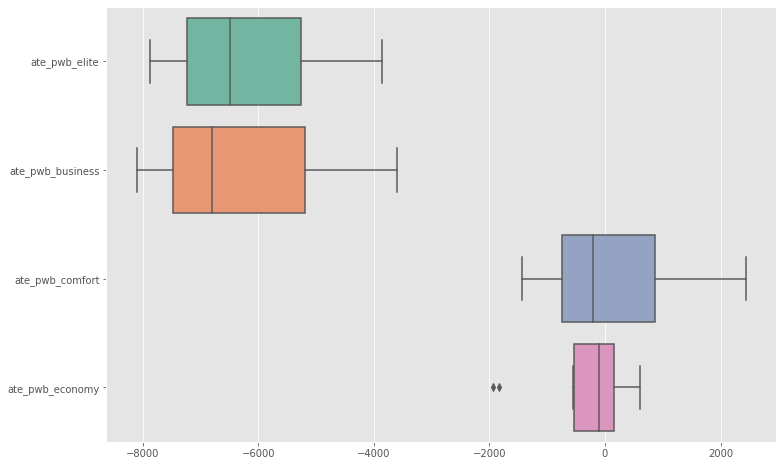

In [192]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# vars = ['ate_pwb_weighted', 'ate_pwb_elite', 'ate_pwb_business', 'ate_pwb_comfort', 'ate_pwb_economy']
# fig = make_subplots(rows=1, cols=len(vars))
# for i, var in enumerate(vars):
#     fig.add_trace(
#         go.Box(y=df_est[var],
#         name=var),
#         row=1, col=i+1
#     )

# fig.update_traces(boxpoints='all', jitter=.3)

ax = sns.boxplot(data=df_est[['ate_pwb_elite', 'ate_pwb_business', 'ate_pwb_comfort', 'ate_pwb_economy']], orient="h", 
                 palette="Set2", order=['ate_pwb_elite', 'ate_pwb_business', 'ate_pwb_comfort', 'ate_pwb_economy'])

#### Heterogeneous ATEs 

In [ ]:
# sns.boxplot(x=[], y="propensity_score", data=data_ps)
# plt.title("Confounding Evidence");
# надо сделать по стратам